functions to make:
- position pdf {x}
- order param pdf {}
- stats on pdfs {}
- wall residence time {}
- bounce angle {}
- collision waiting time {}
- elastic mode amplitudes {}
- KE, PE {x}
- PCA, DMD {}
- MSE {}

plot:
- trajectory colored by time w/ collisions
- trajectory colored by velocity
- magnetization histogram
- position pdf
- bounce angle histogram
- waiting time histogram
- for each collision plot angle vs residence time. or some realignment metric


todo:
* figure out occlusion / make wireless
* figure out tether pulling / make wireless
* calibrate wall position for better bounce detection

There appears to be lots of noise in the spring lengths. this is in part because of interpolation when a node gets occluded. I think this because there is a periodic signal in the spring lengths with the same frequency as the body angle when I look at a plastic wheeled robot doing pure rotation (0 mode) by eye

In [555]:
# Imports
import os
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import rcParams
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import linregress
from scipy.signal import savgol_filter
from scipy.spatial import KDTree


rcParams['animation.ffmpeg_path'] = '/opt/miniconda3/envs/tplax_env/bin/ffmpeg'

bumper_offset = 0.0605 - 0.025 # mm , distance between center of marker and bumper minus distance from corner markers to wall

In [757]:
# Function Defs

# Plot FFT
def plot_fft(time_series, sampling_rate=30, threshold=.8):
    """
    Plot the FFT of a time series.
    
    Parameters:
    time_series: array-like, input signal
    sampling_rate: float, samples per unit time
    """
    n = len(time_series)
    
    # Compute FFT and frequencies
    yf = fft(time_series)
    xf = fftfreq(n, 1/sampling_rate)
    
    # Only plot positive frequencies
    pos_freq_mask = xf >= 0
    Y = 2.0/n * np.abs(yf[pos_freq_mask])
    try:
        peak_ind = find_peaks(Y,threshold)[0][0]
        print(xf[pos_freq_mask][peak_ind])
    except:
        print("no peaks")
        
    # Create subplot with time domain and frequency domain
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Time domain plot
    ax1.plot(np.arange(n)/sampling_rate, time_series)
    ax1.set_title('Time Domain')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    
    # Frequency domain plot
    ax2.plot(xf[pos_freq_mask], Y)
    ax2.set_title('Frequency Domain')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Magnitude')
    
    plt.tight_layout()
    plt.show()
# Function to compute FFT for a single variable
def compute_fft(data):
    n = len(data)  # Number of data points
    fft_values = fft(data)  # Compute FFT
    fft_magnitude = np.abs(fft_values[:n // 2])  # Take magnitude of FFT (first half)
    return fft_magnitude
# Main function to compute and plot averaged FFT
def plot_averaged_fft(df):
    # Ensure the first column is time and extract variables
    time = df.iloc[:, 0]
    variables = df.iloc[:, 1:]

    # Sampling frequency (assume uniform spacing)
    dt = np.mean(np.diff(time))
    sampling_freq = 1 / dt

    # Frequency axis
    n = len(time)
    freqs = np.linspace(0, sampling_freq / 2, n // 2)

    # Compute FFT for each variable and store results
    fft_results = []
    for column in variables.columns:
        fft_magnitude = compute_fft(variables[column].values)
        fft_results.append(fft_magnitude)

    # Average FFT magnitudes
    averaged_fft = np.mean(fft_results, axis=0)

    # Plot averaged FFT
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, averaged_fft, label='Averaged FFT')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('Averaged FFT of Variables')
    plt.grid()
    plt.legend()
    plt.show()
    
    return freqs, averaged_fft

# Bounce angle function defs
def low_pass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter to the data.

    Parameters:
    data (array): Input data to filter
    cutoff (float): Cutoff frequency for the filter
    fs (float): Sampling frequency
    order (int): Order of the Butterworth filter

    Returns:
    array: Filtered data
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)
def detect_collisions(t, x, y, threshold=0.5, cutoff=1.0):
    """
    Detect the time indices of collisions based on peaks in acceleration.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    threshold (float): Threshold for peak detection
    cutoff (float): Cutoff frequency for the low-pass filter

    Returns:
    list of tuples: List of collision indices and types ('vertical' or 'horizontal')
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Compute the change in filtered velocities (acceleration)
    ax = np.gradient(vx_filtered, t)
    ay = np.gradient(vy_filtered, t)

    # Detect peaks in acceleration
    vertical_peaks, _ = find_peaks(np.abs(ax), height=threshold)
    horizontal_peaks, _ = find_peaks(np.abs(ay), height=threshold)

    # Combine and label collisions
    collisions = [(i, 'vertical') for i in vertical_peaks] + [(i, 'horizontal') for i in horizontal_peaks]
    collisions.sort(key=lambda x: x[0])  # Sort by time index

    return collisions
def calculate_collision_wait_time(t, collisions, show = False):
    """
    t: time array, used as input to detect_collisions
    collisions: output of detect_collisions
    
    outputs: 
    wait_times: list of times between collisions
    """
    
    wait_times = []
    indices = []
    for collision_index, collision_type in collisions:
        indices.append(collision_index)
    for i in range(1,len(indices)):
        wait_times.append( t[indices[i]] - t[indices[i-1]])
    return wait_times
def calculate_collision_angles(t, x, y, collision_index, collision_type, steps=5, cutoff=1.0):
    """
    Calculate the incident and rebound angles of an object at the time of collision.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    collision_index (int): Index of the detected collision
    collision_type (str): Type of collision ('vertical' or 'horizontal')
    steps (int): Number of steps before and after the collision to compute velocity
    cutoff (float): Cutoff frequency for the low-pass filter

    Returns:
    tuple: (incident_angle, rebound_angle) in degrees
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Average velocity over a few steps before and after collision
    before_start = max(collision_index - steps, 0)
    before_end = collision_index
    after_start = collision_index + 1
    after_end = min(collision_index + 1 + steps, len(t))

    vx_before = np.mean(vx_filtered[before_start:before_end])
    vy_before = np.mean(vy_filtered[before_start:before_end])
    vx_after = np.mean(vx_filtered[after_start:after_end])
    vy_after = np.mean(vy_filtered[after_start:after_end])

    # Calculate angles based on collision type
    if collision_type == 'vertical':
        # Angles are relative to the vertical wall (x-direction)
        incident_angle = np.degrees(np.arctan2(vy_before, -vx_before))
        rebound_angle = np.degrees(np.arctan2(vy_after, -vx_after))
    elif collision_type == 'horizontal':
        # Angles are relative to the horizontal wall (y-direction)
        incident_angle = np.degrees(np.arctan2(-vx_before, vy_before))
        rebound_angle = np.degrees(np.arctan2(-vx_after, vy_after))
    else:
        raise ValueError("Invalid collision type. Must be 'vertical' or 'horizontal'.")

    return incident_angle, rebound_angle
def plot_collisions(df, fs = 30, cutoff = 1., threshold = 500., steps = 20, vthreshold = 100, 
                    show=False, title=None ):
    # Detect Bounce Angles
    x = df["centroid_x"]
    y = df["centroid_y"]
    t = df["time"]

    collisions = detect_collisions(t, x, y, threshold=threshold, cutoff=cutoff)
    ratios = []
    residence_times = []

    if collisions:
        for collision_index, collision_type in collisions:
            incident, rebound = calculate_collision_angles(t, x, y, collision_index, collision_type, cutoff=cutoff,steps = steps)
            residence_time = calculate_residence_time(t, x, y, collision_index, collision_type, cutoff=cutoff,velocity_threshold=vthreshold)
            ratios.append(rebound/incident)
            residence_times.append(residence_time)
            if show:
                print(f"Collision detected at t = {t[collision_index]:.2f}s (index {collision_index}, type {collision_type})")
                print(f"  Incident Angle: {incident:.2f}°")
                print(f"  Rebound Angle: {rebound:.2f}°")
                print(f"  Residence Time: {residence_time:.3f} s")
        print(f"  # collisions: {len(collisions):.3f}")
    else:
        print("No collisions detected.")
        
    wait_times = calculate_collision_wait_time(t, collisions)
    # remove outliers
    ratios = [ratio for ratio in ratios if abs(ratio-np.mean(ratios)) <= 4*np.std(ratios)]
    wait_times = [ratio for ratio in wait_times if abs(ratio-np.mean(wait_times)) <= 4*np.std(wait_times)]

    # Plot

    fig = plt.figure(figsize=(20, 20))  # Overall figure size
    fig.suptitle(title, fontsize=38, y=0.85)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    gs = GridSpec(2, 2, height_ratios=[3, 1], figure=fig)  # Height ratio: 3:1
    
    # Plot trajectory colored by time
    # Create line segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a colormap
    norm = mcolors.Normalize(vmin=t.min(), vmax=t.max())
    cmap = plt.cm.viridis  # Change colormap if desired
    lc = LineCollection(segments, cmap=cmap, norm=norm, alpha = 0.5)
    lc.set_array(t)  # Map "time" values to colors

    ax1 = fig.add_subplot(gs[0])  # First subplot occupies 3/4 of the height
    ax1.add_collection(lc)
    ax1.set_xlim(-.5,.5)
    ax1.set_ylim(-.5,.5)
    ax1.set_aspect('equal')
#     ax1.color_bar()
#     plt.colorbar(lc, ax=ax1, label='Time')  # Add a colorbar
    ax1.set_title("Trajectory (Time)")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    for collision_index, collision_type in collisions:
        ax1.scatter(df.iloc[collision_index]["centroid_x"] , df.iloc[collision_index]["centroid_y"], color='r' )

    # Plot trajectory colored by velocity
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)
    vel = np.sqrt(vx**2+vy**2)
    norm = mcolors.Normalize(vmin=vel.min(), vmax=vel.max())
    cmap = plt.cm.viridis  # Change colormap if desired
    lc = LineCollection(segments, cmap=cmap, norm=norm, alpha = 0.5)
    lc.set_array(vel)  # Map "time" values to colors
    ax3 = fig.add_subplot(gs[1])  # First subplot occupies 3/4 of the height
    ax3.add_collection(lc)
    ax3.set_xlim(-.5,.5)
    ax3.set_ylim(-.5,.5)
    ax3.set_aspect('equal')
    ax3.set_title("Trajectory (Vel)")
    ax3.set_xlabel("X")
    ax3.get_yaxis().set_visible(False)
    for collision_index, collision_type in collisions:
        ax3.scatter(df.iloc[collision_index]["centroid_x"] , df.iloc[collision_index]["centroid_y"], color='r' )
        
    # Plot Bounce Angle PDF
    ax2 = fig.add_subplot(gs[2])  # Second subplot occupies 1/4 of the height
    ax2.hist(np.array(ratios), bins='auto', color='skyblue', edgecolor='black', density=True)
    ax2.autoscale()  # Adjust axes limits to fit the line
    ax2.set_xlabel("Bounce Angle")
#     ax2.set_ylabel("PDF")
    ax2.set_title("Bounce Angle PDF")
    
    
    # Plot Waiting Time PDF
    ax4 = fig.add_subplot(gs[3])
    ax4.hist(np.array(wait_times), bins='auto', color='skyblue', edgecolor='black', density=True)
    ax4.autoscale()
    ax4.set_xlabel("Time (s)")
    ax4.set_title("Waiting Time PDF")
    gs.update(wspace=0.1, hspace=-0.2)
    if title:
        plt.savefig(title+'.png', transparent=True)
    plt.show()

# Function to compute the curvature of a 2D trajectory
def calculate_curvature(x, y, fs=30, cutoff=1):
    dx = np.gradient(x)
    dy = np.gradient(y)
    dx_filt = low_pass_filter(dx, cutoff=cutoff, fs=fs)
    dy_filt = low_pass_filter(dy, cutoff=cutoff, fs=fs)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    # Curvature formula: k = |x'y" - y'x"| / (x'^2 + y'^2)^(3/2)
    numerator = np.abs(dx * ddy - dy * ddx)
    denominator = (dx**2 + dy**2)**1.5
    curvature = numerator / np.maximum(denominator, 1e-10)  # Avoid division by zero
    return curvature
# Function to identify sharp bends and estimate bend angles
def identify_bends(x, y, curvature, threshold):
#     sharp_bends = np.where(curvature > threshold)[0]
    sharp_bends, _  = find_peaks(np.abs(curvature), height=threshold)
    angles = []

    for idx in sharp_bends:
        if idx == 0 or idx == len(x) - 1:
            continue  # Skip endpoints

        # Calculate vectors before and after the point
        vec1 = np.array([x[idx] - x[idx - 1], y[idx] - y[idx - 1]])
        vec2 = np.array([x[idx + 1] - x[idx], y[idx + 1] - y[idx]])

        # Normalize vectors
        vec1 /= np.linalg.norm(vec1)
        vec2 /= np.linalg.norm(vec2)

        # Compute the angle between vectors
        dot_product = np.clip(np.dot(vec1, vec2), -1.0, 1.0)
        angle = np.arccos(dot_product) * (180 / np.pi)  # Convert to degrees
        angles.append((idx, angle))

    return sharp_bends, angles

def calculate_residence_time(t, x, y, collision_index, collision_type, cutoff=1.0, velocity_threshold=100):
    """
    Calculate the residence time at the wall during a collision.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    collision_index (int): Index of the detected collision
    collision_type (str): Type of collision ('vertical' or 'horizontal')
    cutoff (float): Cutoff frequency for the low-pass filter
    velocity_threshold (float): Threshold for determining "zero" velocity

    Returns:
    float: Residence time in seconds
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Select the velocity component based on collision type
    if collision_type == 'vertical':
        velocity = vx_filtered
    elif collision_type == 'horizontal':
        velocity = vy_filtered
    else:
        raise ValueError("Invalid collision type. Must be 'vertical' or 'horizontal'.")

    # Find the duration for which the velocity is near zero
    start = collision_index
    while start > 0 and np.abs(velocity[start]) < velocity_threshold:
        start -= 1

    end = collision_index
    while end < len(t) - 1 and np.abs(velocity[end]) < velocity_threshold:
        end += 1

    residence_time = t[end] - t[start]
    return residence_time

def animate_scatter(df, output_file="scatter_animation.mp4", fps=30, factor = 1, vis_angle=False, num_points=7):
    """
    Creates and saves an animation of a scatter plot over time.
    
    Parameters:
    df (pd.DataFrame): A DataFrame containing 'time' and multiple 'x', 'y' columns (e.g., '0_x', '0_y', ..., 'N_x', 'N_y').
    output_file (str): Filename for the saved animation.
    fps (int): Frames per second for the animation.
    """
    # Ensure DataFrame is sorted by time
#     df = df.sort_values(by='time').reset_index(drop=True)
    
    # Extract the number of points (assuming column format '0_x', '0_y', ..., 'N_x', 'N_y')
    num_points = len([col for col in df.columns if col.endswith('_x')])-1
    
    # Create figure and axis
    fig, ax = plt.subplots()
    
    # Set axis limits based on data
    all_x = df[[f"{i}_x" for i in range(num_points)]].values
    all_y = df[[f"{i}_y" for i in range(num_points)]].values
    if vis_angle:
        all_angles = df[[f"{i}_angle" for i in range(num_points)]].values
    else:
        all_angles = np.ones(np.shape(all_x))
    ax.set_xlim(all_x.min() - .1, all_x.max() + .1)
    ax.set_ylim(all_y.min() - .1, all_y.max() + .1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal')
    ax.set_title("Scatter Plot Animation Over Time")
    
    # Initialize scatter plot
#     norm = mcolors.Normalize(vmin=-np.pi, vmax=np.pi)
    cmap = cm.hsv
    scatter = ax.scatter(all_x[0,:], all_y[0,:], c=[], cmap=cmap)#, norm=norm)
    fig.colorbar(scatter, ax=ax)
    
    # Precompute titles
    titles = [f"Scatter Plot at Time {t:.1f}" for t in df['time']]
    
    def update(frame):
        if frame % 100 == 0:
            print(frame)
        """Updates the scatter plot for a given frame."""
        coords = [ [all_x[frame,i], all_y[frame,i]] for i in range(num_points)]
        scatter.set_offsets(coords)
        colors = wrap_angle(all_angles[frame,:])
        scatter.set_array(colors)  # Update colors based on angles
        ax.set_title(titles[frame])
        return scatter,
    
    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=int(len(df)/factor), blit=True)
    
    # Save animation
    ani.save(output_file, writer='ffmpeg', fps=fps)
    
    print(f"Animation saved as {output_file}")
    plt.close(fig)
def read_csv_comments(file):
    # Read the CSV file, skipping comment lines
    metadata = {}
    with open(file, "r") as f:
        lines = f.readlines()
        # Separate comments (metadata) from actual data
        data_lines = []
        for line in lines:
            if line.startswith("#"):
                # Extract metadata from comment lines
                key, value = line[2:].strip().split(":", 1)
                metadata[key] = ast.literal_eval(value.strip())
            else:
                # Collect data lines (non-comment lines)
                data_lines.append(line)

    # Now read the CSV data into a DataFrame from the data lines
    from io import StringIO
    data_str = "".join(data_lines)  # Join the data lines back into a string
    df_read = pd.read_csv(StringIO(data_str))

    # Attach the metadata back to the DataFrame
    df_read.attrs = metadata
    return df_read

def shoelace_area(coords):
    """
    Calculate the area of an irregular polygon using the Shoelace Theorem.
    :param coords: List of tuples [(x1, y1), (x2, y2), ..., (xn, yn)] representing the polygon's vertices.
    :return: Absolute area of the polygon.
    """
    n = len(coords)
    if n < 3:
        raise ValueError("A polygon must have at least 3 vertices")
    
    sum1 = sum(coords[i][0] * coords[(i + 1) % n][1] for i in range(n))
    sum2 = sum(coords[i][1] * coords[(i + 1) % n][0] for i in range(n))
    
    area = abs(sum1 - sum2) / 2
    return area

def generate_energy_df(df, C, l0=.1, k=1, m=1):
    """
    df: output of generate_dataframe, with attribute 'n_nodes
    C: list of pairwise node connections
    l0: resting length of spring in [m]
    k: spring constant of springs [N/m]
    m: mass of each node
    
    returns:
    energy: a dataframe containing the distance between each connected node over time
            and the kinetic and potential energy at each time step. Assumes linear 
            kinetic energy dominates over angular.
    """
    energy = []
    n_nodes = df.attrs['n_nodes']
    dt = df['time'].iloc[1]-df['time'].iloc[0]
    for t in range(len(df)):
        row = {}
        PE = 0
        KE = 0
        dft = df.iloc[t]
        coords = [ (dft[f'{i}_x'] , dft[f'{i}_y']) for i in range(1,n_nodes) ]
        row['area'] = shoelace_area(coords)
                        
        # calculate displacement for each spring. ASSUMING no bending which is wrong!!
        for c in C:
            n0x = df[str(c[0])+'_x'].iloc[t] 
            n0y = df[str(c[0])+'_y'].iloc[t]
            n1x = df[str(c[1])+'_x'].iloc[t] 
            n1y = df[str(c[1])+'_y'].iloc[t]
            dist = np.sqrt( (n0x-n1x)**2 + (n0y-n1y)**2 )
            row[str(c[0])+"-"+str(c[1])] = dist
            PE += 0.5*k*(l0-dist)**2
        row['PE'] = PE
        if t>0:
            for n in range(n_nodes):
                vx = (df[str(n)+'_x'].iloc[t]-df[str(n)+'_x'].iloc[t-1])/dt
                vy = (df[str(n)+'_y'].iloc[t]-df[str(n)+'_y'].iloc[t-1])/dt
                v = np.sqrt(vx**2 + vy**2)
                KE += 0.5*m*v**2
        row['KE'] = KE
        energy.append(row)
    return pd.DataFrame(energy)

def generate_mode_df(df):
    """
    df: output of generate_dataframe
    
    returns:
    mode_df: a dataframe where centroid translation and body rotation have been removed
    """
    
    mode = []
    n_nodes = df.attrs['n_nodes']
    dt = df['time'].iloc[1]-df['time'].iloc[0]
    for t in range(len(df)):
        row = {'time':dt*t}
        sample = df.iloc[t]
        angle = sample['body_angle']
        rot_mat = np.array([ [np.cos(angle), np.sin(angle)] , [-np.sin(angle), np.cos(angle)] ])
        for n in range(n_nodes):
            p = [ sample[f'{n}_x']-sample['centroid_x'] , sample[f'{n}_y']-sample['centroid_y']]
            v = rot_mat@p
            row[f'{n}_x'] = v[0]
            row[f'{n}_y'] = v[1]
        mode.append(row)
    return pd.DataFrame(mode)

#def generate_collision_df(df, offset):
    
    
    
def plot_position_pdf(x,y, bins=30, cmap='Blues'):
    """
    Plots a normalized 2D histogram (equivalent to a probability density function).
    
    Parameters:
    - x, y: Data points.
    - bins: Number of bins for the histogram.
    - cmap: Colormap for visualization.
    """
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap=cmap, aspect='auto')
    plt.colorbar(label='Probability Density')
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Normalized 2D Histogram (PDF)')
    plt.show()
def calculate_magnetization(df):
    """
    df: output of generate_dataframe, with attribute 'n_nodes
    returns a list of the magnetizationa at each timestep
    """
    mag = []
    n_nodes = df.attrs['n_nodes']
    for t in range(len(df)):
        step = df.iloc[t]
        m = []
        for n in range(n_nodes):
            m.append( np.exp( 1j * step[f'{n}_angle'] ) )
        mag.append(np.absolute(np.mean(m)))
    return mag
def wrap_angle(angles):
    """Wraps angle values to be within -pi to pi."""
    return [(angle + np.pi) % (2 * np.pi) - np.pi for angle in angles]

def sort_rectangle_clockwise(points):
    # Compute the centroid
    centroid = np.mean(points, axis=0)
    
    # Compute angles relative to centroid and sort clockwise
    angles = np.arctan2(points[:, 1] - centroid[1], points[:, 0] - centroid[0])
    sorted_points = points[np.argsort(angles)]  # Sort in descending order for clockwise
    
    return sorted_points

def offset_rectangle(points, offset):
    """
    Computes the four corners of a rectangle offset inward or outward by a given distance.
    :param points: List of four (x, y) tuples defining the rectangle in order.
    :param offset: Offset distance (positive for outward, negative for inward).
    :return: List of four (x, y) tuples representing the new rectangle's corners.
    """
    points = np.array(points)
    
    # Compute edge vectors and their normals
    edges = np.roll(points, -1, axis=0) - points
    normals = np.column_stack((-edges[:, 1], edges[:, 0]))
    normals = normals / np.linalg.norm(normals, axis=1, keepdims=True)  # Normalize
    
    # Offset each point
    new_points = points + offset * (normals + np.roll(normals, 1, axis=0)) / 2
    
    return new_points.tolist()

def arc_length_metric(traj, time_step, dt):
    n_points = np.shape(traj)[0]
    n_step = int(time_step/dt)
    metric = []
    
    # Precompute all pairwise distances between consecutive points
    diffs = np.linalg.norm(traj[1:] - traj[:-1], axis=1)

    for i in range(n_points - n_step):
        # Calculate the numerator (distance between points separated by n_step)
        num = np.linalg.norm(traj[i] - traj[i + n_step])
        
        # Use the precomputed differences for the denominator
        denom = np.sum(diffs[i:i + n_step - 1])
        
        metric.append(num / denom)

    return metric

def angular_velocity(angle, dt):
    """
    Computes angular velocity from a wrapped angle time series assuming uniform time spacing.
    
    Parameters:
    - angle (numpy array): Angle values wrapped between -pi and pi.
    - dt (float): Time step between consecutive angle measurements.
    
    Returns:
    - omega (numpy array): Angular velocity.
    """
    # Unwrap the angle to prevent discontinuities
    unwrapped_angle = np.unwrap(angle)
    
    # Compute the derivative of the unwrapped angle
    omega = np.gradient(unwrapped_angle, dt)
    
    return omega

def zero_mode_metric(x,y,theta,dt, window = 200, fit = 2):
    x = savgol_filter(x, window, fit)
    y = savgol_filter(y, window, fit)

    traj = np.column_stack((x, y))
    omega = angular_velocity(theta,dt)
    omega = savgol_filter(omega, window, fit)
    n_points = len(x)
    metric = []
    for i in range(n_points):
        metric.append(np.linalg.norm([x[i],y[i]]) / omega[i])
        
    return metric
        

np.float64(0.11013614292625663)

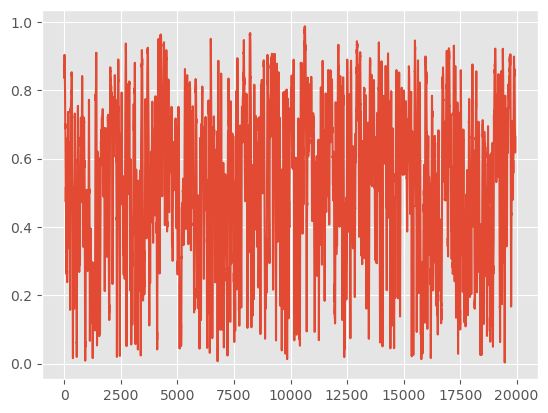

In [723]:
plt.plot(arc_length_metric(traj,2,dt))
n_step = int(2/dt)
sum([np.linalg.norm( traj[a] - traj[a+1]) for a in range(n_step-1)])

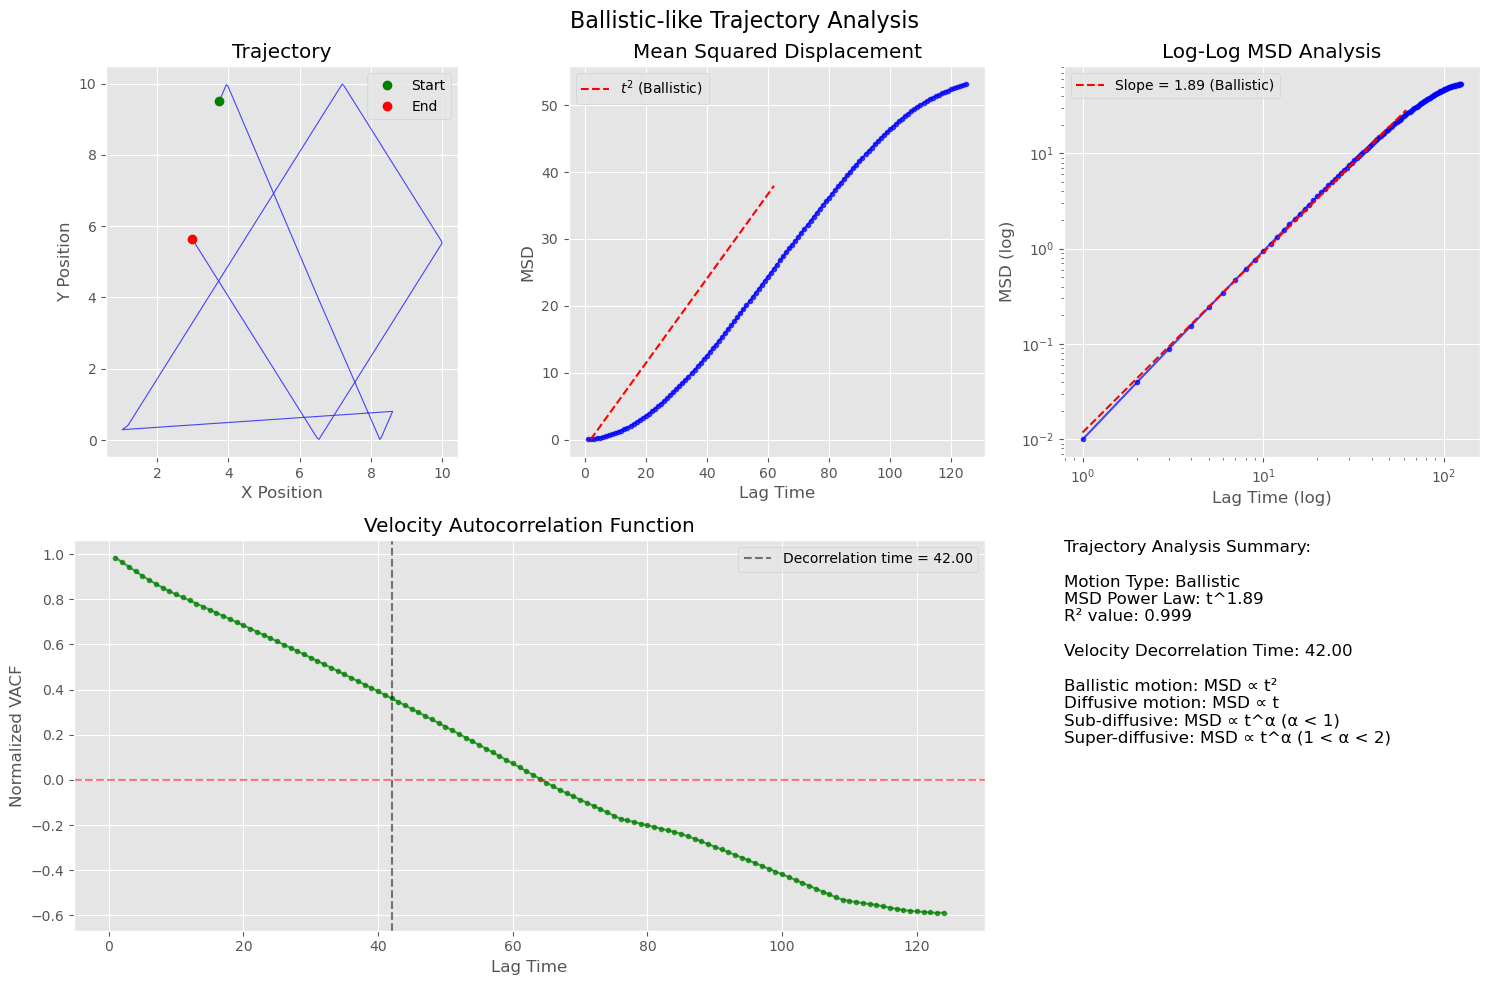

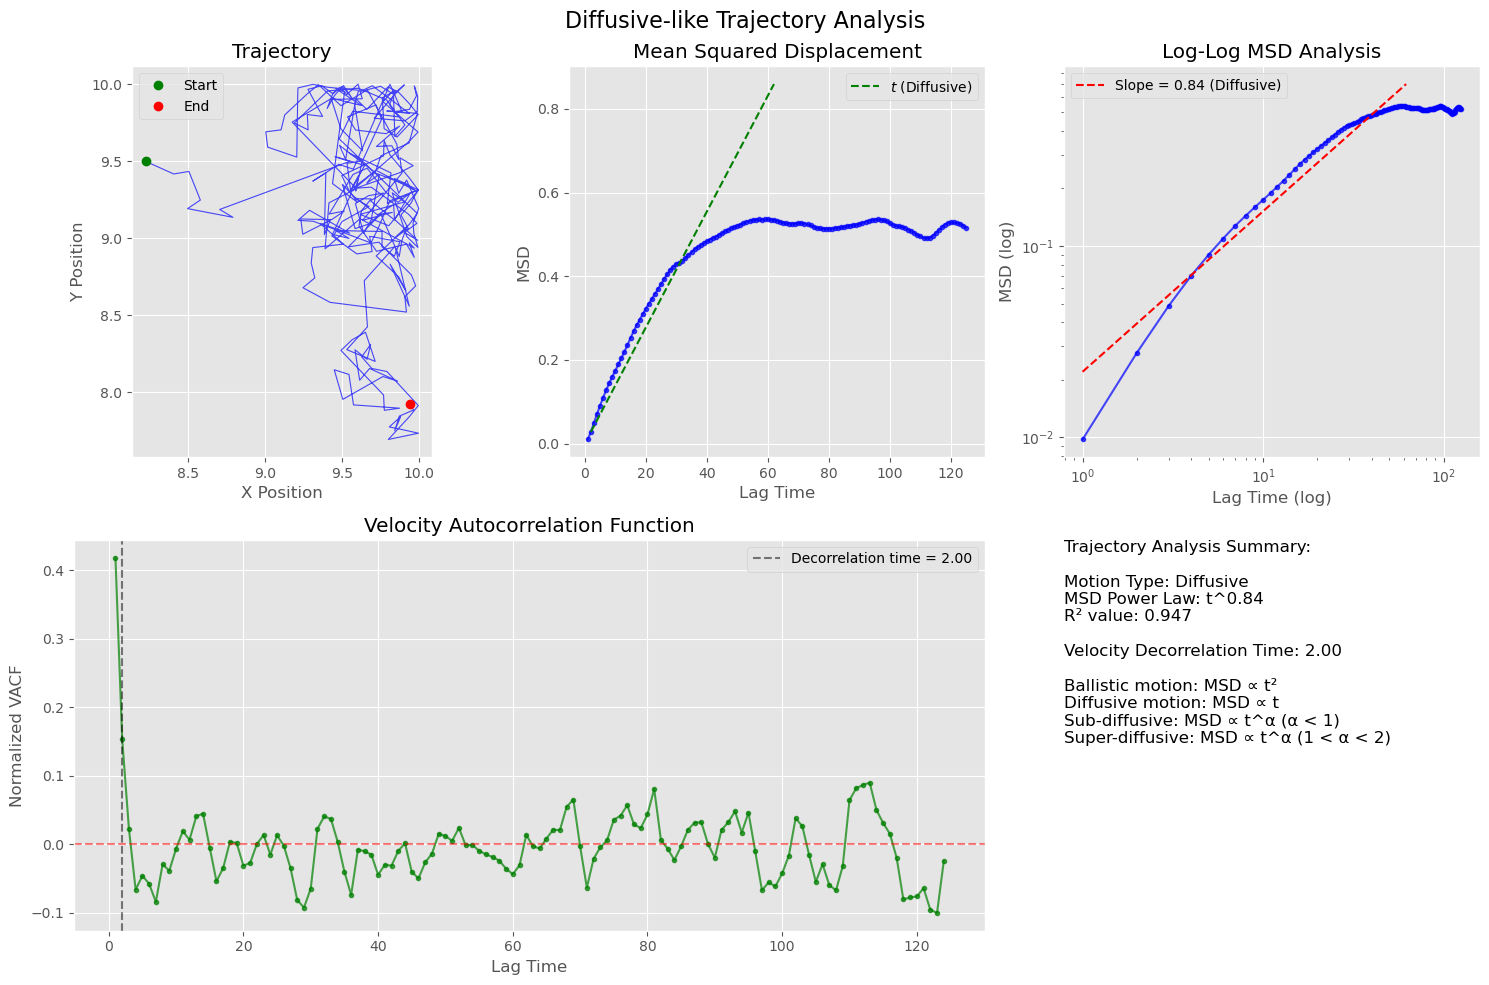

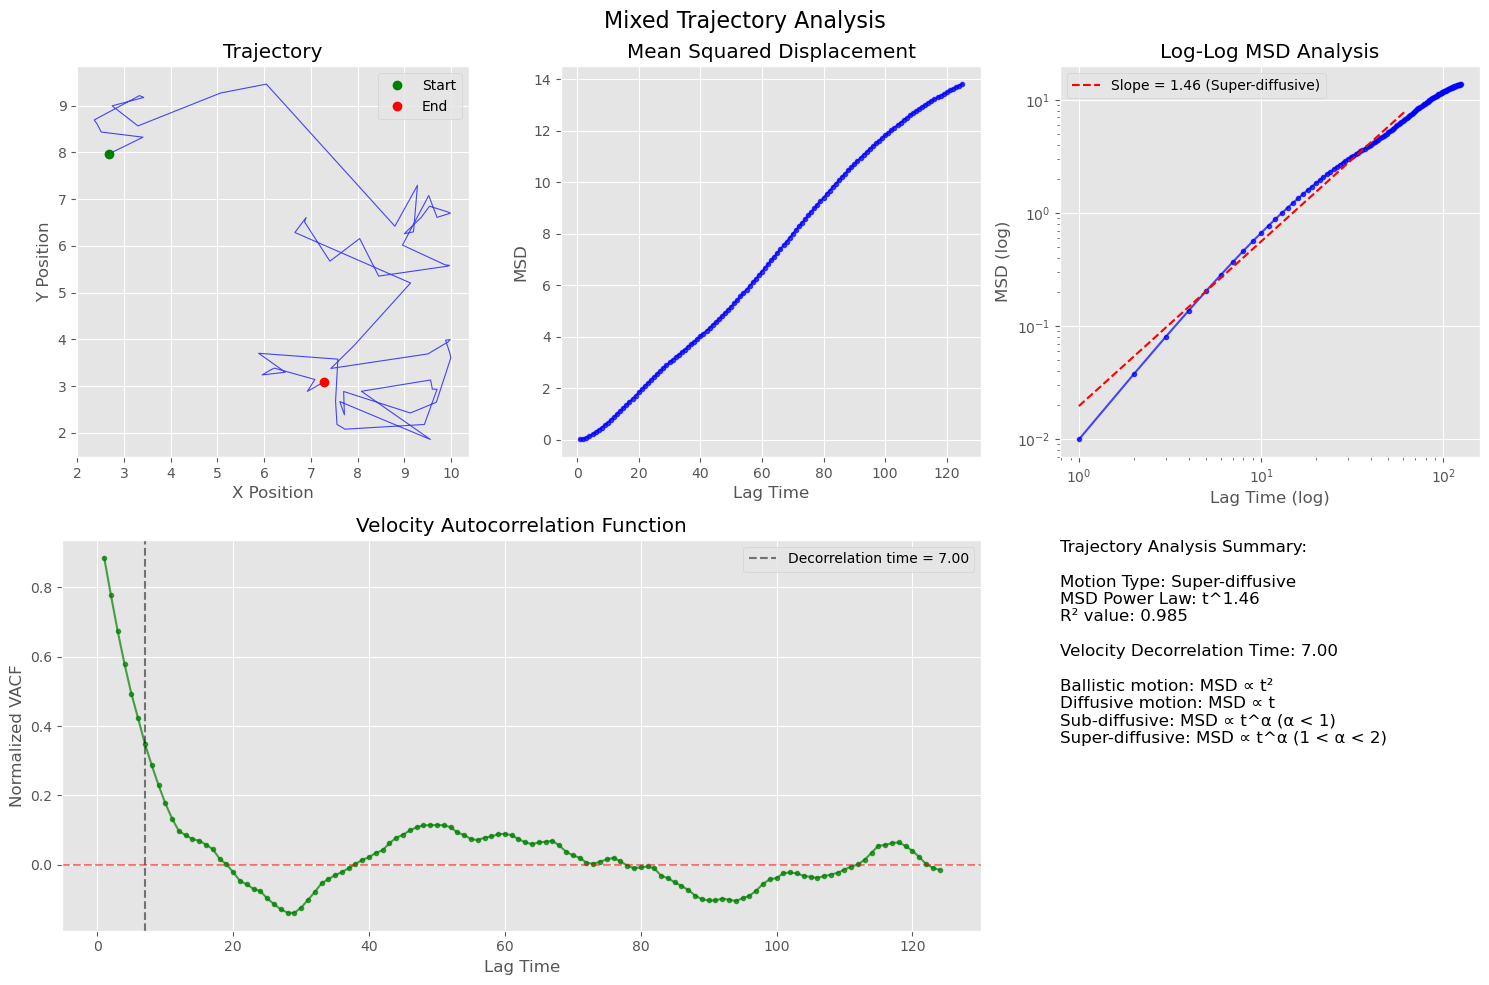


Ballistic-like Trajectory Results:
  motion_type: Ballistic
  msd_slope: 1.8866187294749075
  r_squared: 0.9990594086697389
  decorrelation_time: 42.0

Diffusive-like Trajectory Results:
  motion_type: Diffusive
  msd_slope: 0.8380021861908833
  r_squared: 0.9473868457852427
  decorrelation_time: 2.0

Mixed Trajectory Results:
  motion_type: Super-diffusive
  msd_slope: 1.4553301132175323
  r_squared: 0.9849773117906981
  decorrelation_time: 7.0


In [697]:
# MSD stuff - claude

def calculate_msd(trajectory, max_lag=None):
    """
    Calculate Mean Squared Displacement (MSD) from a trajectory
    
    Parameters:
    -----------
    trajectory : numpy.ndarray
        Array of shape (n_points, 2) containing (x, y) coordinates
    max_lag : int, optional
        Maximum lag time to calculate MSD for. Default is N/4
        
    Returns:
    --------
    lag_times : numpy.ndarray
        Array of lag times
    msd : numpy.ndarray
        Array of MSD values corresponding to lag times
    """
    n_points = len(trajectory)
    
    if max_lag is None:
        max_lag = n_points // 4  # Using N/4 as a rule of thumb
    
    # Initialize arrays
    msd = np.zeros(max_lag)
    counts = np.zeros(max_lag)
    
    # Calculate squared displacements for all possible time origins
    for lag in range(1, max_lag + 1):
        # Squared displacements for lag τ
        squared_diff = np.sum((trajectory[lag:] - trajectory[:-lag])**2, axis=1)
        msd[lag-1] = np.mean(squared_diff)
        counts[lag-1] = len(squared_diff)
    
    lag_times = np.arange(1, max_lag + 1)
    
    return lag_times, msd

def calculate_velocity(trajectory, dt=1.0):
    """
    Calculate velocities from position trajectory
    
    Parameters:
    -----------
    trajectory : numpy.ndarray
        Array of shape (n_points, 2) containing (x, y) coordinates
    dt : float, optional
        Time step between consecutive positions
        
    Returns:
    --------
    velocities : numpy.ndarray
        Array of shape (n_points-1, 2) containing velocity vectors
    """
    velocities = (trajectory[1:] - trajectory[:-1]) / dt
    return velocities

def calculate_vacf(velocities, max_lag=None):
    """
    Calculate Velocity Autocorrelation Function (VACF)
    
    Parameters:
    -----------
    velocities : numpy.ndarray
        Array of shape (n_points, 2) containing velocity vectors
    max_lag : int, optional
        Maximum lag time to calculate VACF for. Default is N/4
        
    Returns:
    --------
    lag_times : numpy.ndarray
        Array of lag times
    vacf : numpy.ndarray
        Array of normalized VACF values
    """
    n_points = len(velocities)
    
    if max_lag is None:
        max_lag = n_points // 4
    
    # Initialize arrays
    vacf = np.zeros(max_lag)
    counts = np.zeros(max_lag)
    
    # Calculate zero-lag autocorrelation (normalization factor)
    zero_lag = np.mean(np.sum(velocities**2, axis=1))
    
    # Calculate autocorrelation for different lags
    for lag in range(1, max_lag + 1):
        # Dot products for all possible time origins
        dot_products = np.sum(velocities[lag:] * velocities[:-lag], axis=1)
        vacf[lag-1] = np.mean(dot_products) / zero_lag
        counts[lag-1] = len(dot_products)
    
    lag_times = np.arange(1, max_lag + 1)
    
    return lag_times, vacf

def analyze_trajectory(trajectory, dt=1.0, max_lag=None, title=None):
    """
    Analyze trajectory: calculate MSD and VACF, identify motion type, and plot results
    
    Parameters:
    -----------
    trajectory : numpy.ndarray
        Array of shape (n_points, 2) containing (x, y) coordinates
    dt : float, optional
        Time step between consecutive positions
    max_lag : int, optional
        Maximum lag time for analysis. Default is N/4
    title : str, optional
        Title for the plot
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure object containing the plots
    results : dict
        Dictionary containing analysis results
    """
    # Calculate MSD
    lag_times_msd, msd = calculate_msd(trajectory, max_lag)
    lag_times_msd = lag_times_msd * dt  # Convert to actual time
    
    # Calculate velocities and VACF
    velocities = calculate_velocity(trajectory, dt)
    lag_times_vacf, vacf = calculate_vacf(velocities, max_lag)
    lag_times_vacf = lag_times_vacf * dt  # Convert to actual time
    
    # Log-log regression for MSD to determine the slope
    log_lag = np.log10(lag_times_msd)
    log_msd = np.log10(msd)
    
    # Use only the first half of the data for fitting (more reliable)
    fit_length = len(log_lag) // 2
    slope, intercept, r_value, p_value, std_err = linregress(log_lag[:fit_length], log_msd[:fit_length])
    
    # Determine motion type based on MSD slope
    if slope > 1.8:
        motion_type = "Ballistic"
        expected_slope = 2.0
    elif slope > 1.2:
        motion_type = "Super-diffusive"
        expected_slope = slope
    elif slope > 0.8:
        motion_type = "Diffusive"
        expected_slope = 1.0
    elif slope > 0:
        motion_type = "Sub-diffusive"
        expected_slope = slope
    else:
        motion_type = "Confined"
        expected_slope = 0.0
    
    # Create plots
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig)
    
    # 1. Trajectory plot
    ax_traj = fig.add_subplot(gs[0, 0])
    ax_traj.plot(trajectory[:, 0], trajectory[:, 1], 'b-', alpha=0.7, linewidth=0.8)
    ax_traj.plot(trajectory[0, 0], trajectory[0, 1], 'go', label='Start')
    ax_traj.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label='End')
    ax_traj.set_xlabel('X Position')
    ax_traj.set_ylabel('Y Position')
    ax_traj.set_title('Trajectory')
    ax_traj.legend()
    ax_traj.set_aspect('equal')
    
    # 2. MSD plot (linear scale)
    ax_msd_lin = fig.add_subplot(gs[0, 1])
    ax_msd_lin.plot(lag_times_msd, msd, 'b-', marker='o', markersize=3, alpha=0.7)
    ax_msd_lin.set_xlabel('Lag Time')
    ax_msd_lin.set_ylabel('MSD')
    ax_msd_lin.set_title('Mean Squared Displacement')
    
    # Plot reference slopes for ballistic and diffusive motion
    if expected_slope in [1.0, 2.0]:
        x_ref = np.array([lag_times_msd[1], lag_times_msd[fit_length-1]])
        if expected_slope == 2.0:
            y_ref = msd[1] * (x_ref / lag_times_msd[1])**2
            ax_msd_lin.plot(x_ref, y_ref, 'r--', label=r'$t^2$ (Ballistic)')
        elif expected_slope == 1.0:
            y_ref = msd[1] * (x_ref / lag_times_msd[1])
            ax_msd_lin.plot(x_ref, y_ref, 'g--', label=r'$t$ (Diffusive)')
        ax_msd_lin.legend()
    
    # 3. MSD log-log plot
    ax_msd_log = fig.add_subplot(gs[0, 2])
    ax_msd_log.loglog(lag_times_msd, msd, 'b-', marker='o', markersize=3, alpha=0.7)
    
    # Add regression line
    fit_times = np.logspace(np.log10(lag_times_msd[0]), np.log10(lag_times_msd[fit_length-1]), 100)
    fit_msd = 10**(intercept) * fit_times**slope
    ax_msd_log.loglog(fit_times, fit_msd, 'r--', 
                     label=f'Slope = {slope:.2f} ({motion_type})')
    
    ax_msd_log.set_xlabel('Lag Time (log)')
    ax_msd_log.set_ylabel('MSD (log)')
    ax_msd_log.set_title('Log-Log MSD Analysis')
    ax_msd_log.legend()
    
    # 4. VACF plot
    ax_vacf = fig.add_subplot(gs[1, :2])
    ax_vacf.plot(lag_times_vacf, vacf, 'g-', marker='o', markersize=3, alpha=0.7)
    ax_vacf.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    # Calculate decorrelation time (time at which VACF drops to 1/e)
    try:
        # Find where VACF drops below 1/e
        decorr_idx = np.where(vacf < 1/np.e)[0][0]
        decorr_time = lag_times_vacf[decorr_idx]
        ax_vacf.axvline(x=decorr_time, color='k', linestyle='--', alpha=0.5,
                       label=f'Decorrelation time = {decorr_time:.2f}')
    except IndexError:
        decorr_time = None
    
    ax_vacf.set_xlabel('Lag Time')
    ax_vacf.set_ylabel('Normalized VACF')
    ax_vacf.set_title('Velocity Autocorrelation Function')
    if decorr_time is not None:
        ax_vacf.legend()
    
    # 5. Summary text
    ax_summary = fig.add_subplot(gs[1, 2])
    ax_summary.axis('off')
    
    summary_text = (
        f"Trajectory Analysis Summary:\n\n"
        f"Motion Type: {motion_type}\n"
        f"MSD Power Law: t^{slope:.2f}\n"
        f"R² value: {r_value**2:.3f}\n\n"
    )
    
    if decorr_time is not None:
        summary_text += f"Velocity Decorrelation Time: {decorr_time:.2f}\n\n"
    else:
        summary_text += "Velocity Decorrelation Time: Not reached within lag range\n\n"
    
    summary_text += (
        f"Ballistic motion: MSD ∝ t²\n"
        f"Diffusive motion: MSD ∝ t\n"
        f"Sub-diffusive: MSD ∝ t^α (α < 1)\n"
        f"Super-diffusive: MSD ∝ t^α (1 < α < 2)"
    )
    
    ax_summary.text(0, 1, summary_text, va='top', ha='left', fontsize=12)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    
    # Prepare results dictionary
    results = {
        "motion_type": motion_type,
        "msd_slope": slope,
        "r_squared": r_value**2,
        "decorrelation_time": decorr_time
    }
    
    plt.savefig(title+'_msd_vaf.png', dpi=300)
    return fig, results

# Example usage with a simulated trajectory
def generate_example_trajectory(n_points=1000, motion_type="ballistic", box_size=10, dt=0.1):
    """
    Generate an example trajectory for demonstration
    
    Parameters:
    -----------
    n_points : int
        Number of points in trajectory
    motion_type : str
        Type of motion: "ballistic", "diffusive", or "mixed"
    box_size : float
        Size of confining box
    dt : float
        Time step
        
    Returns:
    --------
    trajectory : numpy.ndarray
        Array of shape (n_points, 2) containing (x, y) coordinates
    """
    trajectory = np.zeros((n_points, 2))
    
    # Initial position
    trajectory[0] = np.random.uniform(0, box_size, 2)
    
    # Initial velocity
    velocity = np.random.normal(0, 1, 2)
    velocity = velocity / np.linalg.norm(velocity) * 1.0  # Normalize
    
    # Collision probability per step
    if motion_type == "ballistic":
        p_collision = 0.01  # Low collision probability
    elif motion_type == "diffusive":
        p_collision = 0.5  # High collision probability
    else:  # mixed
        p_collision = 0.1  # Intermediate
    
    # Generate trajectory
    for i in range(1, n_points):
        # Check for collision
        if np.random.random() < p_collision:
            # Randomize velocity direction
            angle = np.random.uniform(0, 2*np.pi)
            velocity = np.array([np.cos(angle), np.sin(angle)])
            
        # Calculate new position
        new_pos = trajectory[i-1] + velocity * dt
        
        # Handle wall collisions
        for j in range(2):  # For x and y dimensions
            if new_pos[j] < 0:
                new_pos[j] = -new_pos[j]  # Reflect
                velocity[j] = -velocity[j]
            elif new_pos[j] > box_size:
                new_pos[j] = 2*box_size - new_pos[j]  # Reflect
                velocity[j] = -velocity[j]
        
        trajectory[i] = new_pos
    
    return trajectory

def main():
    """
    Main function to demonstrate the trajectory analysis
    """
    # Generate example trajectories
    np.random.seed(42)  # For reproducibility
    
    # Generate three different types of trajectories
    traj_ballistic = generate_example_trajectory(motion_type="ballistic", n_points=500)
    traj_diffusive = generate_example_trajectory(motion_type="diffusive", n_points=500)
    traj_mixed = generate_example_trajectory(motion_type="mixed", n_points=500)
    
    # Analyze each trajectory
    fig1, results1 = analyze_trajectory(traj_ballistic, title="Ballistic-like Trajectory Analysis")
    fig2, results2 = analyze_trajectory(traj_diffusive, title="Diffusive-like Trajectory Analysis")
    fig3, results3 = analyze_trajectory(traj_mixed, title="Mixed Trajectory Analysis")
    
    plt.show()
    
    # Print results
    print("\nBallistic-like Trajectory Results:")
    for key, value in results1.items():
        print(f"  {key}: {value}")
    
    print("\nDiffusive-like Trajectory Results:")
    for key, value in results2.items():
        print(f"  {key}: {value}")
    
    print("\nMixed Trajectory Results:")
    for key, value in results3.items():
        print(f"  {key}: {value}")

# If the file is run directly (not imported)
if __name__ == "__main__":
    main()
    
def analyze_real_trajectory(trajectory_file=None, trajectory_data=None, dt=1.0, max_lag=None, title="Real Trajectory Analysis"):
    """
    Analyze a real trajectory from a file or provided data
    
    Parameters:
    -----------
    trajectory_file : str, optional
        Path to file containing trajectory data (x, y coordinates)
    trajectory_data : numpy.ndarray, optional
        Array of shape (n_points, 2) containing (x, y) coordinates
    dt : float
        Time step between consecutive positions
    max_lag : int, optional
        Maximum lag time for analysis
    title : str
        Title for the plot
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure object containing the plots
    results : dict
        Dictionary containing analysis results
    """
    if trajectory_file is not None:
        # Load trajectory from file
        try:
            trajectory = np.loadtxt(trajectory_file)
            if trajectory.shape[1] > 2:
                # If file has more than 2 columns, use the first two as x, y
                trajectory = trajectory[:, :2]
        except Exception as e:
            print(f"Error loading trajectory file: {e}")
            return None, None
    elif trajectory_data is not None:
        trajectory = trajectory_data
    else:
        print("Error: No trajectory data provided")
        return None, None
    
    # Analyze trajectory
    fig, results = analyze_trajectory(trajectory, dt=dt, max_lag=max_lag, title=title)
    
    return fig, results

In [706]:
# MSD stuff - chatgpt
def compute_vdaf(trajectory, dt, max_lag=None):
    num_points = len(trajectory)
    if max_lag == None:
        max_lag = int(num_points / 2)
        
    velocities = np.diff(trajectory, axis=0) / dt  # Compute velocity using fixed dt
    v_norms = np.linalg.norm(velocities, axis=1, keepdims=True)
    unit_velocities = velocities / np.where(v_norms == 0, 1, v_norms)  # Normalize

    vdaf = []
    for lag in range(1, max_lag):
        valid_pairs = len(unit_velocities) - lag
        if valid_pairs <= 0:
            break
        dot_products = np.sum(unit_velocities[:-lag] * unit_velocities[lag:], axis=1)
        vdaf.append(np.mean(dot_products))

    return np.arange(1, len(vdaf) + 1) * dt, np.array(vdaf)  # Scale lags by dt

def compute_dispersion_ratio(trajectory):
    displacements = trajectory - trajectory[0]  # Displacement from initial position
    var_x = np.var(displacements[:, 0])
    var_total = np.var(displacements[:, 0]) + np.var(displacements[:, 1])
    return var_x / var_total if var_total > 0 else 0

def compute_msdd(trajectory, dt, window=5, max_lag = None):
    num_points = len(trajectory)
    if max_lag == None:
        time_lags = np.arange(1, num_points // 2)
    else:
        time_lags = np.arange(1,max_lag)
    msd = []

    for lag in time_lags:
        displacements = trajectory[lag:] - trajectory[:-lag]
        squared_displacements = np.sum(displacements**2, axis=1)
        msd.append(np.mean(squared_displacements))  # Time-averaged MSD

    time_lags = time_lags * dt  # Convert lags to actual time
    log_time = np.log(time_lags)
    log_msd = np.log(msd)
    msdd = np.gradient(log_msd, log_time)  # Differentiate wrt log-time

    return log_time, savgol_filter(msdd, window, 2)

def recurrence_times(trajectory, epsilon):
    """
    Compute recurrence times for a trajectory within a threshold epsilon using KDTree for efficiency.
    
    Parameters:
        trajectory (ndarray): NxD array representing N time steps of a D-dimensional trajectory.
        epsilon (float): Distance threshold for recurrence.
    
    Returns:
        rec_times (ndarray): Array of recurrence times.
    """
    tree = KDTree(trajectory)
    rec_times = []
    
    for i in range(len(trajectory)):
        indices = tree.query_ball_point(trajectory[i], epsilon)
        future_indices = [j for j in indices if j > i]
        if future_indices:
            rec_times.append(min(future_indices) - i)
    
    return np.array(rec_times)

def recurrence_rate(trajectory, epsilon):
    """
    Compute the fraction of trajectory points that revisit any previous point within epsilon using KDTree.
    
    Parameters:
        trajectory (ndarray): NxD array representing N time steps of a D-dimensional trajectory.
        epsilon (float): Distance threshold for recurrence.
    
    Returns:
        rate (float): Recurrence rate (fraction of revisited points).
    """
    tree = KDTree(trajectory)
    visited = np.zeros(len(trajectory), dtype=bool)
    
    for i in range(len(trajectory)):
        indices = tree.query_ball_point(trajectory[i], epsilon)
        visited[indices] = True
    
    return np.sum(visited) / len(trajectory)

def choose_epsilon(trajectory, num_epsilons=20):
    """
    Automatically selects an optimal epsilon based on recurrence rate stabilization and plots the recurrence rate vs. epsilon curve.
    
    Parameters:
        trajectory (ndarray): NxD array representing N time steps of a D-dimensional trajectory.
        num_epsilons (int): Number of epsilon values to test.
    
    Returns:
        optimal_epsilon (float): Chosen epsilon value.
    """
    bounding_box_size = np.max(trajectory, axis=0) - np.min(trajectory, axis=0)
    eps_values = np.linspace(0.1, np.mean(bounding_box_size) / 10, num_epsilons)
    recurrence_rates = [recurrence_rate(trajectory, eps) for eps in eps_values]
    
    # Find the "knee point" where recurrence rate stabilizes
    diffs = np.diff(recurrence_rates)
    optimal_index = np.argmax(diffs < np.mean(diffs))
    optimal_epsilon = eps_values[optimal_index]
    
    # Plot recurrence rate vs epsilon
    plt.figure()
    plt.plot(eps_values, recurrence_rates, marker='o', linestyle='-')
    plt.axvline(optimal_epsilon, color='r', linestyle='--', label=f'Optimal ε = {optimal_epsilon:.2f}')
    plt.xlabel("Epsilon")
    plt.ylabel("Recurrence Rate")
    plt.title("Recurrence Rate vs. Epsilon")
    plt.legend()
    plt.show()
    
    return optimal_epsilon

def plot_trajectory_results(trajectory, vdaf, metric, msdd, filename="analysis.png"):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    
    # Trajectory plot
    axs[0, 0].plot(trajectory[:, 0], trajectory[:, 1])
    axs[0, 0].set_title("Trajectory")
    axs[0, 0].set_xlabel("X position")
    axs[0, 0].set_ylabel("Y position")
    
    # VDAF plot
    axs[0, 1].plot(vdaf[0], vdaf[1])
    axs[0, 1].set_title("Velocity Direction Autocorrelation Function (VDAF)")
    axs[0, 1].set_xlabel("Time Lag")
    axs[0, 1].set_ylabel("Autocorrelation")
    
    # MSDD plot
    axs[1, 0].plot(msdd[0], msdd[1])
    axs[1, 0].set_title("Mean Squared Displacement Derivative (MSDD)")
    axs[1, 0].set_xlabel("log(Time)")
    axs[1, 0].set_ylabel("Derivative")
    
    # Dispersion ratio text
    axs[1, 1].plot(np.linspace(0,dt*len(metric),len(metric)),metric)
    axs[1, 1].set_ylim(0,1.1)
    axs[1, 1].set_xlabel("Time")
    axs[1, 1].set_title("Dispersion Metric")

    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()



In [602]:
# Grid based recurrence times

def calculate_recurrence_times_grid(trajectory, n_bins, dt = 1/30, grid_limits=None):
    """
    Calculate the recurrence times using a grid-based method with a fixed number of bins.
    
    Parameters:
    - trajectory: A 2D numpy array where each row is the (x, y) position of the particle at a time step.
    - n_bins: The number of bins (grid cells) in each dimension.
    - grid_limits: The limits of the grid [min_x, max_x, min_y, max_y].
    
    Returns:
    - recurrence_times: A list of recurrence times (in terms of the number of time steps).
    """
    n = len(trajectory)
    recurrence_times = []
    
    if grid_limits is None:
        min_x, max_x = np.min(trajectory[:, 0]), np.max(trajectory[:, 0])
        min_y, max_y = np.min(trajectory[:, 1]), np.max(trajectory[:, 1])
        grid_limits = [min_x, max_x, min_y, max_y]  
        
    # Calculate the size of each grid cell based on the number of bins
    grid_width_x = (grid_limits[1] - grid_limits[0]) / n_bins
    grid_width_y = (grid_limits[3] - grid_limits[2]) / n_bins
    
    # Define the grid occupancy dictionary
    grid_occupancy = {}

    for i in range(n):
        # Get the grid cell index for the current position
        x_idx = int((trajectory[i, 0] - grid_limits[0]) / grid_width_x)
        y_idx = int((trajectory[i, 1] - grid_limits[2]) / grid_width_y)
        
        # Check if this grid cell has been visited before
        grid_key = (x_idx, y_idx)
        
        if grid_key in grid_occupancy:
            recurrence_times.append(i - grid_occupancy[grid_key])
        
        # Update the last visit time for the current grid cell
        grid_occupancy[grid_key] = i
    
    return np.array(recurrence_times)*dt

def plot_recurrence_time_statistics(recurrence_times):
    """
    Plot the recurrence time statistics (histogram and cumulative distribution function).
    
    Parameters:
    - recurrence_times: A list or array of recurrence times.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot histogram of recurrence times
    plt.subplot(1, 2, 1)
    plt.hist(recurrence_times, bins=30, density=True)
    plt.title("Recurrence Time Histogram")
    plt.xlabel("Recurrence Time (steps)")
    plt.ylabel("Probability Density")
    
    # Plot cumulative distribution
    plt.subplot(1, 2, 2)
    plt.hist(recurrence_times, bins=30, cumulative=True, density=True)
    plt.title("Cumulative Recurrence Time Distribution")
    plt.xlabel("Recurrence Time (steps)")
    plt.ylabel("Cumulative Probability")
    
    plt.tight_layout()
    plt.show()

def analyze_recurrence_time_grid(trajectory, n_bins=50, grid_limits=None):
    """
    Analyze the diffusion behavior based on recurrence times using a grid-based method with a fixed number of bins.
    
    Parameters:
    - trajectory: A 2D numpy array with the particle's trajectory.
    - n_bins: The number of bins (grid cells) in each dimension.
    - grid_limits: The limits of the grid [min_x, max_x, min_y, max_y]. If None, auto-calculated.
    
    Returns:
    - A message indicating whether the motion is super-diffusive or sub-diffusive.
    """
    if grid_limits is None:
        min_x, max_x = np.min(trajectory[:, 0]), np.max(trajectory[:, 0])
        min_y, max_y = np.min(trajectory[:, 1]), np.max(trajectory[:, 1])
        grid_limits = [min_x, max_x, min_y, max_y]
    
    # Calculate recurrence times using grid-based method
    recurrence_times = calculate_recurrence_times_grid(trajectory, n_bins, grid_limits)
    
    # Compute the scaling exponent of the recurrence times
    log_recurrence_times = np.log(recurrence_times)
    
    # Fit a linear model to the log-log scale of recurrence times to estimate the exponent
    log_log_bins = np.log(np.arange(1, len(recurrence_times) + 1))
    slope, _ = np.polyfit(log_log_bins, log_recurrence_times, 1)
    
    print(f"Slope of log-log recurrence times: {slope}")
    
    if slope > 1:
        print("Motion is super-diffusive.")
    elif slope < 1:
        print("Motion is sub-diffusive.")
    else:
        print("Motion is normal diffusive.")
    
    plot_recurrence_time_statistics(recurrence_times)




/var/folders/30/gfnvy8ms33q6k0hcsvgz7x6c0000gn/T/ipykernel_7449/2185728317.py:79: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(rec_times),
/var/folders/30/gfnvy8ms33q6k0hcsvgz7x6c0000gn/T/ipykernel_7449/2185728317.py:80: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(rec_times)
/var/folders/30/gfnvy8ms33q6k0hcsvgz7x6c0000gn/T/ipykernel_7449/2185728317.py:167: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


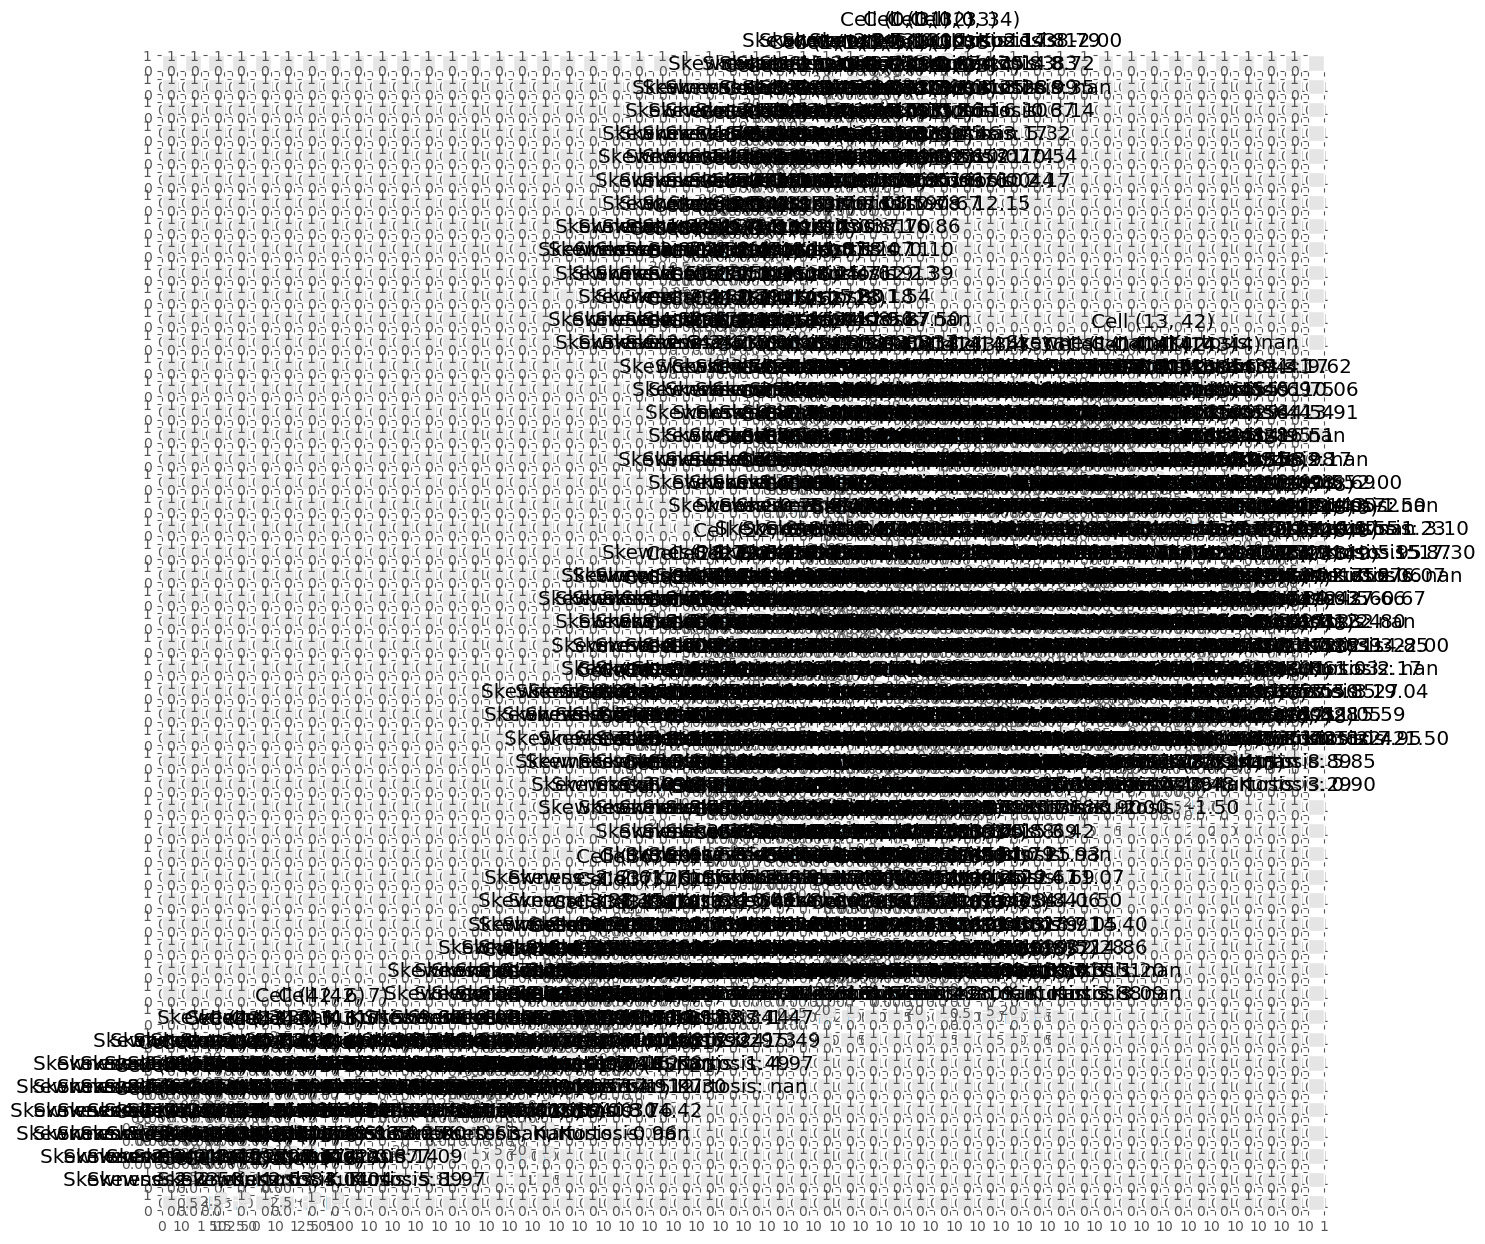

In [618]:
# Waiting time distribution analysis
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, powerlaw, expon, lognorm
from scipy.optimize import curve_fit

def calculate_recurrence_times_per_cell(trajectory, n_bins, grid_limits):
    """
    Calculate the recurrence times and store recurrence time statistics for each grid cell.
    
    Parameters:
    - trajectory: A 2D numpy array where each row is the (x, y) position of the particle at a time step.
    - n_bins: The number of bins (grid cells) in each dimension.
    - grid_limits: The limits of the grid [min_x, max_x, min_y, max_y].
    
    Returns:
    - recurrence_time_stats: A dictionary where keys are grid cells, and values are lists of recurrence times.
    """
    n = len(trajectory)
    recurrence_time_stats = {}
    
    # Calculate the size of each grid cell based on the number of bins
    grid_width_x = (grid_limits[1] - grid_limits[0]) / n_bins
    grid_width_y = (grid_limits[3] - grid_limits[2]) / n_bins
    
    # Define the grid occupancy dictionary
    grid_occupancy = {}

    for i in range(n):
        # Get the grid cell index for the current position
        x_idx = int((trajectory[i, 0] - grid_limits[0]) / grid_width_x)
        y_idx = int((trajectory[i, 1] - grid_limits[2]) / grid_width_y)
        
        # Check if this grid cell has been visited before
        grid_key = (x_idx, y_idx)
        
        if grid_key in grid_occupancy:
            recurrence_time = i - grid_occupancy[grid_key]
            if grid_key not in recurrence_time_stats:
                recurrence_time_stats[grid_key] = []
            recurrence_time_stats[grid_key].append(recurrence_time)
        
        # Update the last visit time for the current grid cell
        grid_occupancy[grid_key] = i
    
    return recurrence_time_stats

def calculate_waiting_time_distribution(recurrence_time_stats):
    """
    Calculate the detailed waiting time distribution for each grid cell.
    
    Parameters:
    - recurrence_time_stats: A dictionary where keys are grid cells, and values are lists of recurrence times.
    
    Returns:
    - waiting_time_dist: A dictionary where keys are grid cells, and values are the distribution (list) of waiting times for each cell.
    """
    waiting_time_dist = {}
    
    for cell, rec_times in recurrence_time_stats.items():
        waiting_time_dist[cell] = rec_times  # Store the full distribution of waiting times
    
    return waiting_time_dist

def calculate_statistical_moments(waiting_time_dist):
    """
    Calculate the skewness and kurtosis for the waiting time distribution of each grid cell.
    
    Parameters:
    - waiting_time_dist: A dictionary where keys are grid cells, and values are the waiting time distributions for each cell.
    
    Returns:
    - stats: A dictionary where keys are grid cells, and values are dictionaries containing skewness and kurtosis.
    """
    stats = {}
    
    for cell, rec_times in waiting_time_dist.items():
        stats[cell] = {
            'skewness': skew(rec_times),
            'kurtosis': kurtosis(rec_times)
        }
    
    return stats

def fit_distribution(waiting_times):
    """
    Fit a distribution to the waiting time data (e.g., power law, exponential, log-normal).
    
    Parameters:
    - waiting_times: List of waiting times for a single grid cell.
    
    Returns:
    - best_fit: The best-fitting distribution model (type and parameters).
    """
    # Try fitting to different distributions (Power Law, Exponential, Log-Normal)
    try:
        # Fit to Power Law
        params_powerlaw, _ = powerlaw.fit(waiting_times)
        powerlaw_fit = ('Power Law', params_powerlaw)
    except:
        powerlaw_fit = None
    
    try:
        # Fit to Exponential
        def exp_func(x, lambd):
            return lambd * np.exp(-lambd * x)
        
        popt_exp, _ = curve_fit(exp_func, np.array(waiting_times), np.ones_like(waiting_times))
        exp_fit = ('Exponential', popt_exp)
    except:
        exp_fit = None
    
    try:
        # Fit to Log-Normal
        def lognorm_func(x, mu, sigma):
            return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))
        
        popt_lognorm, _ = curve_fit(lognorm_func, np.array(waiting_times), np.ones_like(waiting_times))
        lognorm_fit = ('Log-Normal', popt_lognorm)
    except:
        lognorm_fit = None
    
    return powerlaw_fit, exp_fit, lognorm_fit

def plot_waiting_time_distribution(waiting_time_dist, stats, grid_limits, n_bins):
    """
    Plot the waiting time distributions for each grid cell and show the statistical moments (skewness, kurtosis).
    
    Parameters:
    - waiting_time_dist: Dictionary of waiting time distributions for each grid cell.
    - stats: Statistical moments (skewness and kurtosis) for each grid cell.
    - grid_limits: The limits of the grid [min_x, max_x, min_y, max_y].
    - n_bins: Number of grid cells in each dimension.
    """
    fig, axes = plt.subplots(n_bins, n_bins, figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for i in range(n_bins):
        for j in range(n_bins):
            # Access the corresponding grid cell
            cell = (i, j)
            if cell in waiting_time_dist:
                # Plot the waiting time distribution for the current grid cell
                ax = axes[i, j]
                rec_times = waiting_time_dist[cell]
                ax.hist(rec_times, bins=20, density=True, alpha=0.75, color='skyblue')
                
#                 # Plot fitted distribution (optional)
#                 powerlaw_fit, exp_fit, lognorm_fit = fit_distribution(rec_times)
                
#                 # Add the fitting curves to the plot
#                 if powerlaw_fit:
#                     ax.plot(np.arange(min(rec_times), max(rec_times), 0.1), 
#                             powerlaw.pdf(np.arange(min(rec_times), max(rec_times), 0.1), *powerlaw_fit[1]), 
#                             label="Power Law", color='red')
#                 if exp_fit:
#                     ax.plot(np.arange(min(rec_times), max(rec_times), 0.1), 
#                             expon.pdf(np.arange(min(rec_times), max(rec_times), 0.1), *exp_fit[1]), 
#                             label="Exponential", color='green')
#                 if lognorm_fit:
#                     ax.plot(np.arange(min(rec_times), max(rec_times), 0.1), 
#                             lognorm.pdf(np.arange(min(rec_times), max(rec_times), 0.1), *lognorm_fit[1]), 
#                             label="Log-Normal", color='purple')
                
                # Add skewness and kurtosis to the plot
                ax.set_title(f"Cell {cell}\nSkewness: {stats[cell]['skewness']:.2f}, Kurtosis: {stats[cell]['kurtosis']:.2f}")
                ax.legend()
                
    plt.show()

def analyze_wtd(trajectory, n_bins=50, grid_limits=None):
    """
    Analyze the diffusion behavior based on waiting time distributions using a grid-based method.
    
    Parameters:
    - trajectory: A 2D numpy array with the particle's trajectory.
    - n_bins: The number of bins (grid cells) in each dimension.
    - grid_limits: The limits of the grid [min_x, max_x, min_y, max_y]. If None, auto-calculated.
    """
    if grid_limits is None:
        min_x, max_x = np.min(trajectory[:, 0]), np.max(trajectory[:, 0])
        min_y, max_y = np.min(trajectory[:, 1]), np.max(trajectory[:, 1])
        grid_limits = [min_x, max_x, min_y, max_y]
    
    # Calculate recurrence time statistics for each grid cell
    recurrence_time_stats = calculate_recurrence_times_per_cell(trajectory, n_bins, grid_limits)
    
    # Calculate the waiting time distribution for each grid cell
    waiting_time_dist = calculate_waiting_time_distribution(recurrence_time_stats)
    
    # Calculate statistical moments (skewness, kurtosis)
    stats = calculate_statistical_moments(waiting_time_dist)
    
    # Plot the waiting time distributions and moments
    plot_waiting_time_distribution(waiting_time_dist, stats, grid_limits, n_bins)

# Example usage
# Simulate a 2D random walk (for example) or load your trajectory
n_steps = 20000
trajectory = np.cumsum(np.random.randn(n_steps, 2), axis=0)

# Define number of bins (adjust as necessary for your data)
n_bins = 50

analyze_wtd(trajectory, n_bins)


## Load robot data

In [405]:
robots = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/020625/020625_rubber_shortL_1_robot.csv')
robotl = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/020625/020625_rubber_longL_1_robot.csv')
C = [(0,1),(0,2),(0,3),(0,4),(0,5),(0,6),(1,2),(2,3),(3,4),(4,5),(5,6),(6,1)]
df = generate_energy_df(robot, C, k=10)


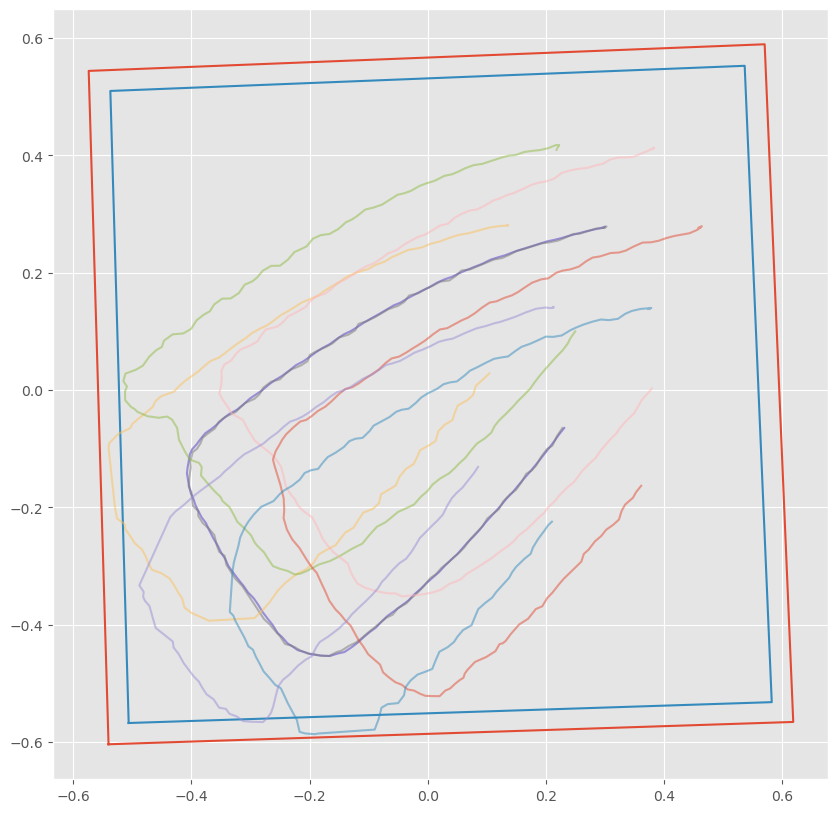

In [511]:
date = '020625'
file = 'clipped_longL_1'
robot = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/' 
                          + date + '/' + date + '_' + file + '_robot.csv')

corners = sort_rectangle_clockwise(np.array(robot.attrs['corner_locs'][:]))
corners0 = offset_rectangle(corners,bumper_offset+.035)
corners = np.vstack([corners, corners[0]])
corners0 = np.vstack([corners0, corners0[0]])
x,y = zip(*corners)
x0,y0 = zip(*corners0)

n=200
plt.figure(figsize=(10,10))
plt.plot(x,y)
plt.plot(x0,y0)
plt.plot(robot['centroid_x'][0:n],robot['centroid_y'][0:n])
for i in range(7):
    plt.plot(robot[f'{i}_x'][0:n],robot[f'{i}_y'][0:n],alpha=0.5)

In [483]:
np.vstack([corners,corners[0]])

array([[-0.57393081,  0.54414287],
       [ 0.56847451,  0.58759264],
       [ 0.61793679, -0.56553121],
       [-0.53953974, -0.60294135],
       [-0.57393081,  0.54414287]])

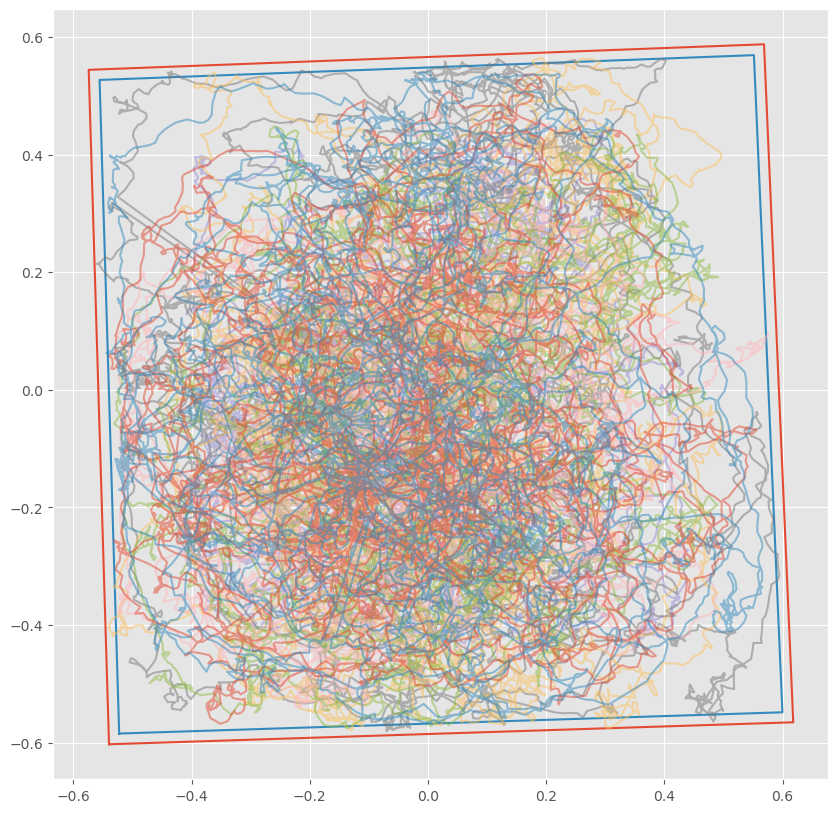

In [512]:
date = '020625'
file = 'rubber_shortL_1'
robot = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/' 
                          + date + '/' + date + '_' + file + '_robot.csv')

corners = sort_rectangle_clockwise(np.array(robot.attrs['corner_locs'][:]))
corners0 = offset_rectangle(corners,bumper_offset)
corners = np.vstack([corners, corners[0]])
corners0 = np.vstack([corners0, corners0[0]])
x,y = zip(*corners)
x0,y0 = zip(*corners0)

n=10000
plt.figure(figsize=(10,10))
plt.plot(x,y)
plt.plot(x0,y0)
for i in range(7):
    plt.plot(robot[f'{i}_x'][0:n],robot[f'{i}_y'][0:n],alpha=0.5)

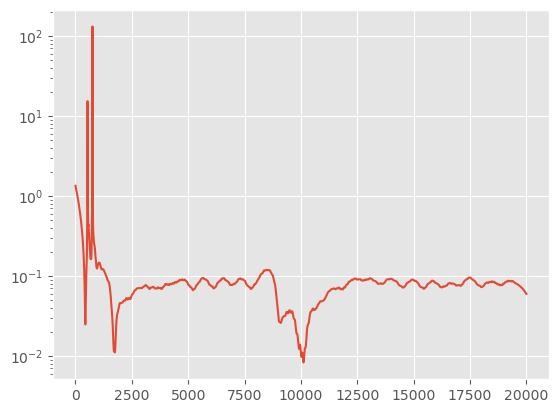

In [767]:
date = '020625'
file = 'rubber_longL_1'
robot = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/' 
                          + date + '/' + date + '_' + file + '_robot.csv')
x = robot['centroid_x']
y = robot['centroid_y']

dt = 1/30
theta = robot['body_angle']
plt.semilogy(np.abs(zero_mode_metric(x,y,theta,dt,window = 1000)))

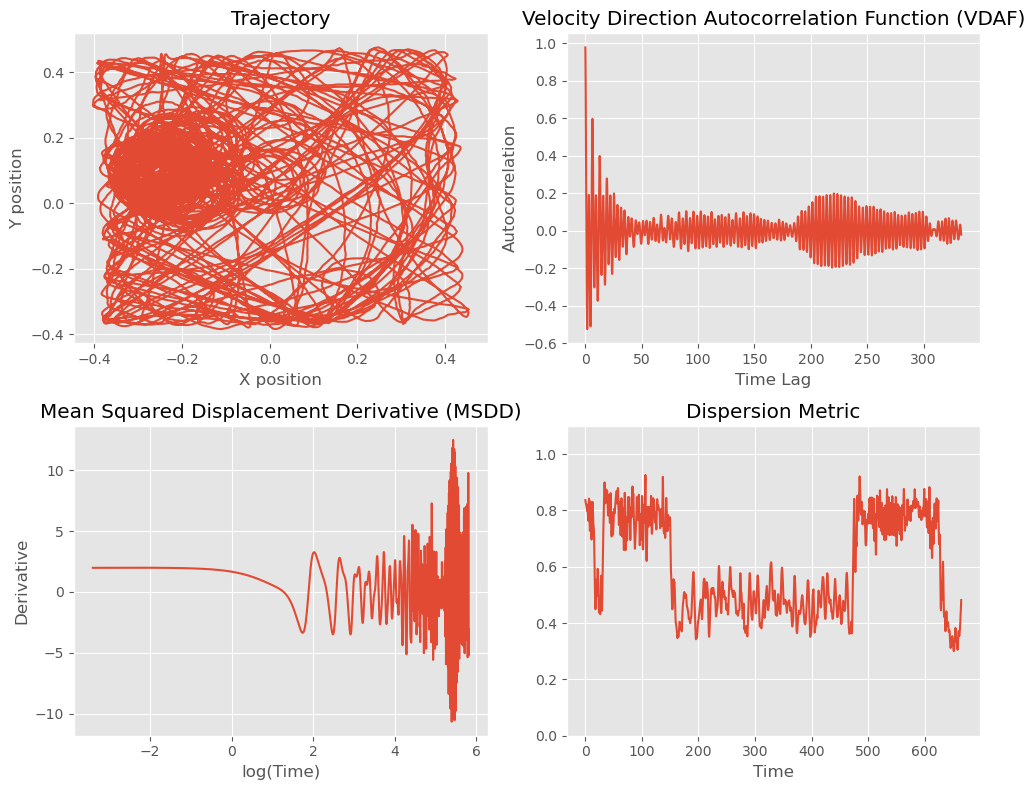

(<Figure size 1500x1000 with 5 Axes>,
 {'motion_type': 'Sub-diffusive',
  'msd_slope': np.float64(0.18218367023602872),
  'r_squared': np.float64(0.2488509654171945),
  'decorrelation_time': np.float64(0.8666666666666667)})

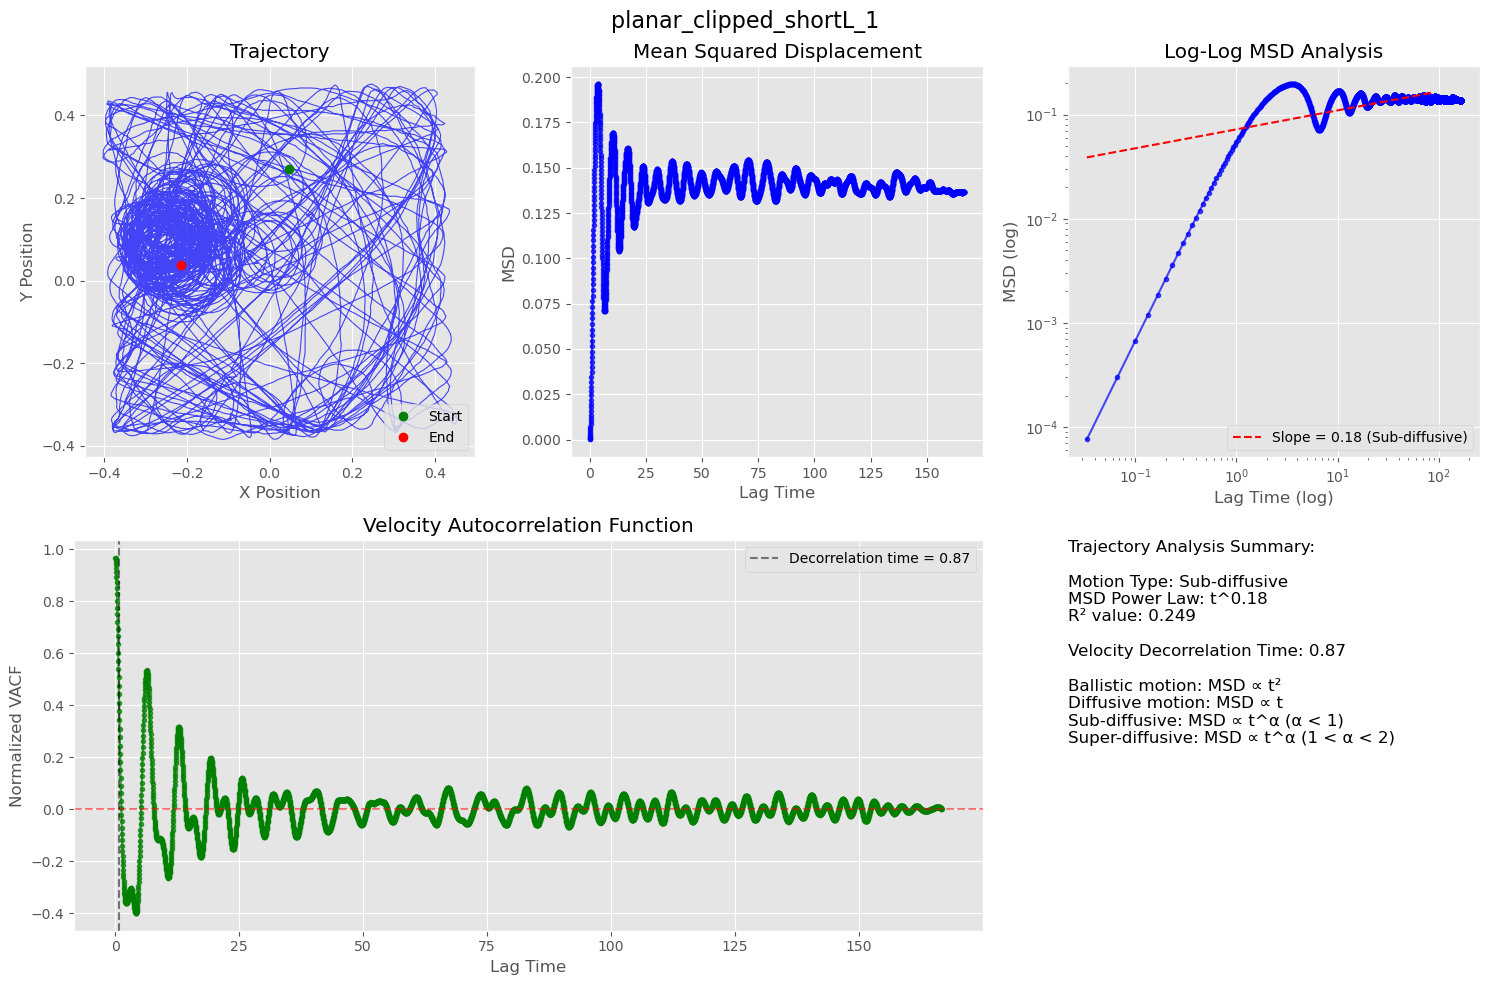

In [717]:
date = '022625'
file = 'planar_clipped_shortL_1'
robot = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/' 
                          + date + '/' + date + '_' + file + '_robot.csv')
x = robot['centroid_x']
y = robot['centroid_y']
traj = np.column_stack((x, y))
dt = 1/30
# Compute metrics
vdaf = compute_vdaf(traj, dt)#, max_lag = int(2/dt))
# grid_size = grid_choose_size(traj)
rec_times = calculate_recurrence_times_grid(traj, 100, dt = dt)
msdd = compute_msdd(traj,dt)#, max_lag = int(2/dt))
metric = arc_length_metric(traj,2,dt)
metric = savgol_filter(metric, 200, 2)
# Plot results
plot_trajectory_results(traj, vdaf, metric, msdd, filename = file+'_vdaf_msdd.png')
analyze_real_trajectory(trajectory_data=traj, dt=dt, title = file)

/var/folders/30/gfnvy8ms33q6k0hcsvgz7x6c0000gn/T/ipykernel_7449/1275789211.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i, j].set_ylim(0,1)
/var/folders/30/gfnvy8ms33q6k0hcsvgz7x6c0000gn/T/ipykernel_7449/1275789211.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i, j].set_ylim(0,1)
/var/folders/30/gfnvy8ms33q6k0hcsvgz7x6c0000gn/T/ipykernel_7449/1275789211.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i, j].set_ylim(0,1)
/var/folders/30/gfnvy8ms33q6k0hcsvgz7x6c0000gn/T/ipykernel_7449/1275789211.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i, j].set_ylim(0,1)
/var/folders/30/gfnvy8ms33q6k0hcsvgz7x6c0000gn/T/ipykernel_7449/1275789211.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i, j].set_ylim(0,1)
/var/folders/30/gfnvy8ms33q6k0hcsvgz7x6c

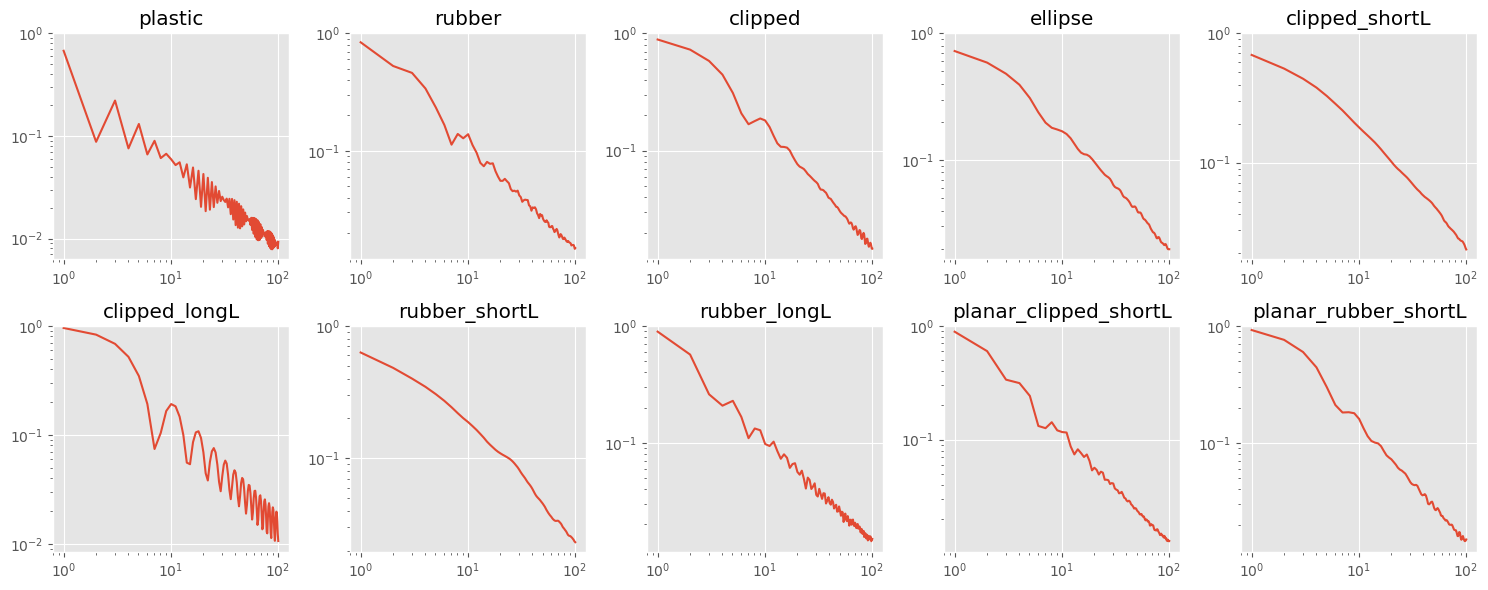

In [747]:
file_list = [ '020325/020325_plastic',
              '020325/020325_rubber',
              '020325/020325_clipped',
              '020325/020325_ellipse',
              '020625/020625_clipped_shortL',
              '020625/020625_clipped_longL',
              '020625/020625_rubber_shortL',
              '020625/020625_rubber_longL',
              '022625/022625_planar_clipped_shortL',
              '022625/022625_planar_rubber_shortL']

dt = 1/30
steps = np.linspace(1,101,100)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # figsize adjusts the overall size

# Example of plotting something on each subplot
for i in range(2):
    for j in range(5):
        k = i*5+j
        
        file = file_list[k]
        robot = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/' 
                              + file + '_1_robot.csv')
        x = robot['centroid_x']
        y = robot['centroid_y']
        traj = np.column_stack((x, y))
        means = []
        for step in steps:
            metric = arc_length_metric(traj,step,dt)
            metric = savgol_filter(metric, 200, 2)
            means.append(np.mean(metric))
        axs[i, j].loglog(steps,means)
        axs[i, j].set_title(file.split('/')[1][7:])
        axs[i, j].set_ylim(0,1)

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.savefig('metric.png',dpi=300)
plt.show()
# for file in file_list:
#     robot = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/' 
#                               + file + '_1_robot.csv')
#     x = robot['centroid_x']
#     y = robot['centroid_y']
#     traj = np.column_stack((x, y))
    
#     means = []
#     for i in steps:
#         metric = arc_length_metric(traj,i,dt)
#         metric = savgol_filter(metric, 200, 2)
#         means.append(np.mean(metric))
#     plt.plot(steps,means)

In [745]:
plt.savefig('metric.png',dpi=300)

<Figure size 640x480 with 0 Axes>

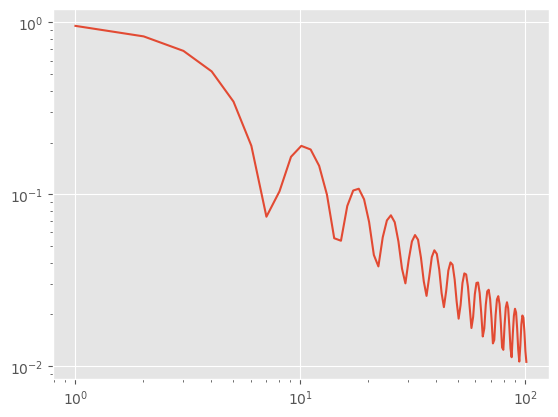

In [739]:
date = '020625'
file = 'clipped_longL_1'
robot = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/' 
                          + date + '/' + date + '_' + file + '_robot.csv')
x = robot['centroid_x']
y = robot['centroid_y']
traj = np.column_stack((x, y))
dt = 1/30

steps = np.linspace(1,101,100)
means = []
for i in steps:
    metric = arc_length_metric(traj,i,dt)
    metric = savgol_filter(metric, 200, 2)
    means.append(np.mean(metric))
plt.loglog(steps,means)


In [740]:
file.split('_')

['clipped', 'longL', '1']

In [267]:
modes = generate_mode_df(robot)
animate_scatter(modes, factor = 10)

/var/folders/30/gfnvy8ms33q6k0hcsvgz7x6c0000gn/T/ipykernel_7449/1314834223.py:430: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(all_x[0,:], all_y[0,:], c=[], cmap=cmap)#, norm=norm)


0
0
0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Animation saved as scatter_animation.mp4


In [533]:
v = np.gradient(traj,axis=0)/dt

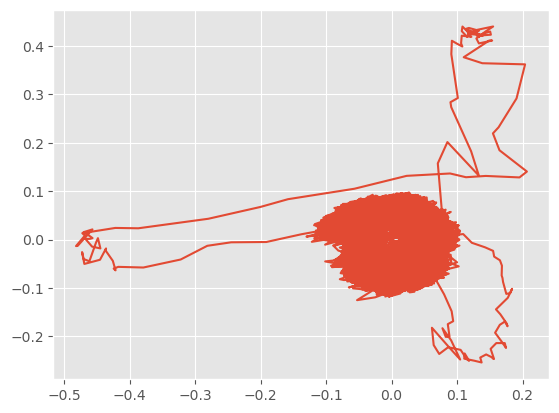

In [535]:
plt.plot(v[:,0],v[:,1])

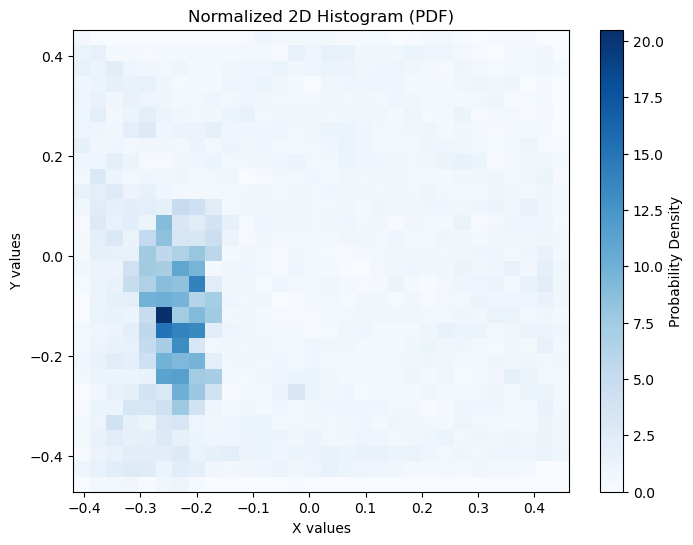

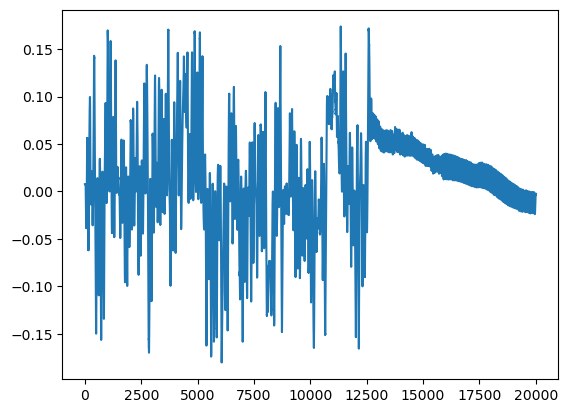

In [221]:
x = robot['centroid_x']
y = robot['centroid_y']
plot_position_pdf(x,y)
plt.plot(x*y)

In [93]:
m = calculate_magnetization(robot)
m1 = calculate_magnetization(static)

# Make Plots

  # collisions: 6.000


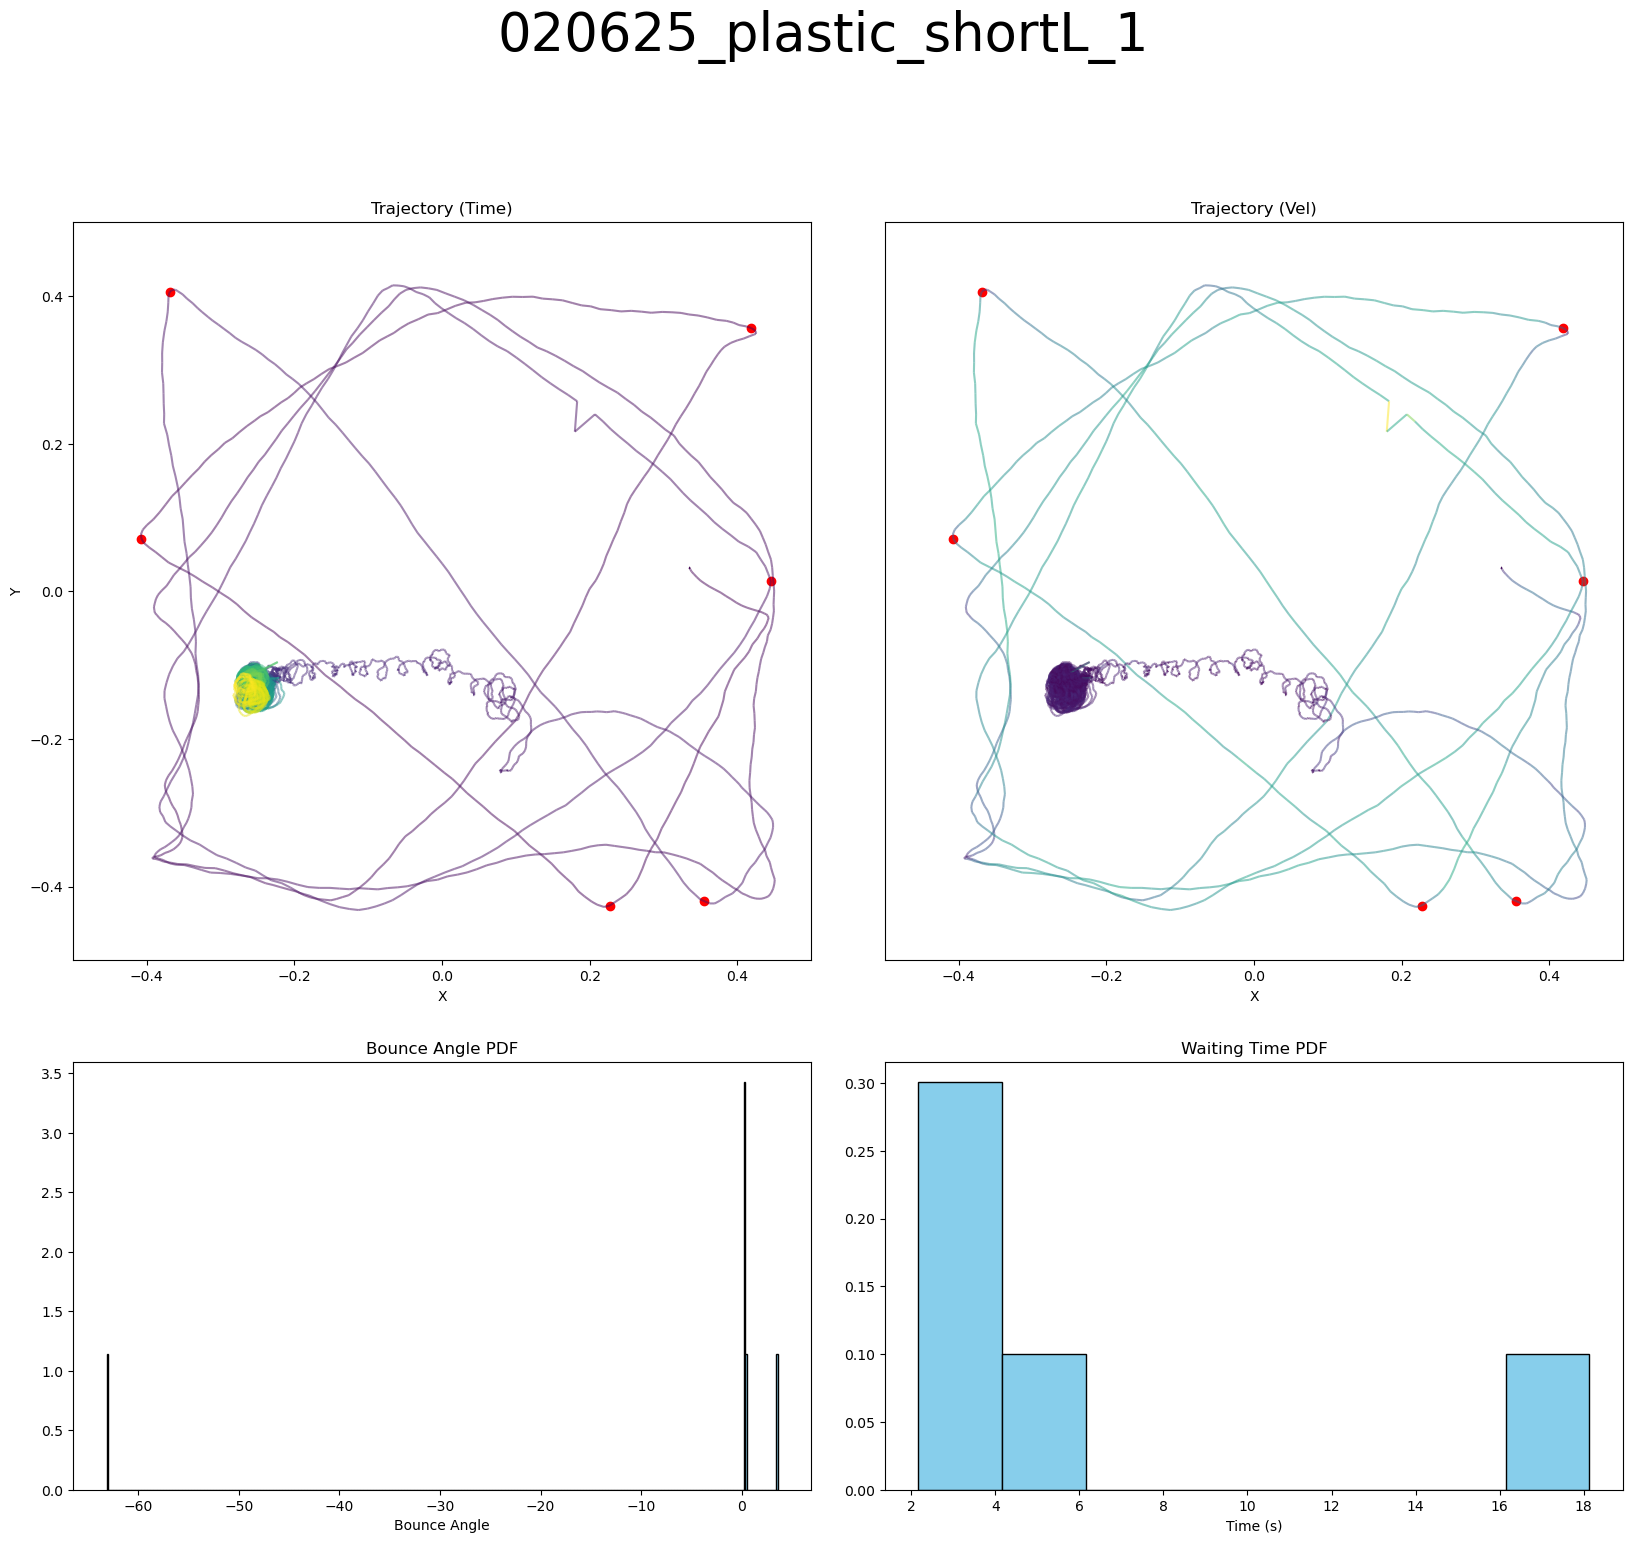

In [401]:
file = '020625_plastic_shortL_1'
robot = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/020625/'+file+'_robot.csv') 
plot_collisions(robot, threshold = 1, title = file)

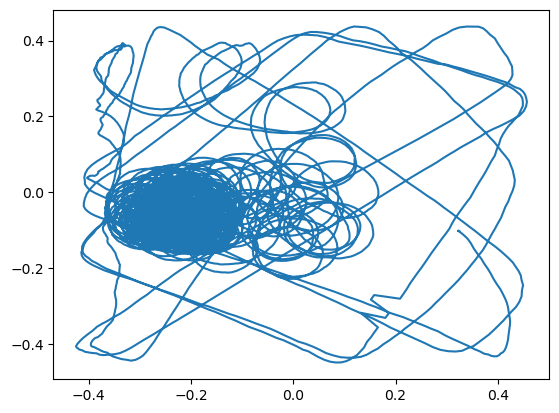

In [386]:
plt.plot(robot['centroid_x'],robot['centroid_y'])

# Entropy Stuff

In [232]:
Mobj = EH.MSobject('K2En')
plt.figure()
date = '020325_'
files = ['plastic_1','rubber_1','clipped_1','ellipse_1','tape_3']
for file in files:
    robot = read_csv_comments('/Users/alexleffell/Documents/PhD/tplax/Data/020325/'+date+file+'_robot.csv') 
    MSx, _ = EH.MSEn(robot['centroid_x'], Mobj, Scales = 5, Methodx = 'modified')
    plt.plot(MSx, label=file)
plt.legend()

 .

AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

<Figure size 640x480 with 0 Axes>

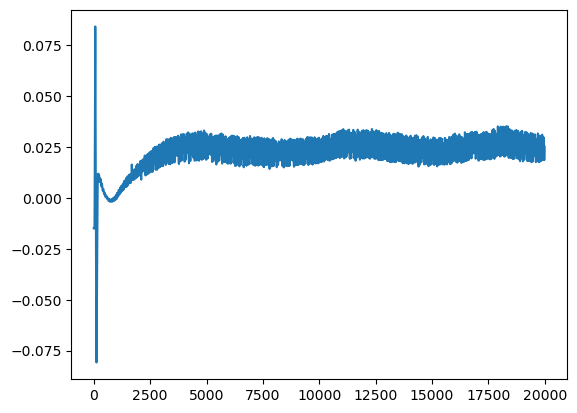

In [218]:
plt.plot(x*y)

# Try PCA

In [542]:
# PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.signal import spectrogram
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.fft import fft, fftfreq


n = 10
cols = []
for i in range(n):
    cols.append("PC"+str(i+1))

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(robot_df)

# Apply PCA
pca = PCA(n_components=n)
principal_components = pca.fit_transform(scaled_data)
first_component_projected = np.array(pca.inverse_transform(principal_components))

# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=cols)

pca.components_[0]



array([-0.27801217, -0.09684936,  0.2096551 , -0.05775667, -0.04396603,
        0.20971627, -0.13469338,  0.06747926,  0.32115403, -0.28032497,
        0.00186025,  0.24096854, -0.05612125, -0.05888194,  0.24300679,
       -0.1336578 ,  0.020529  ,  0.25372432, -0.09317052, -0.04026382,
        0.19617505, -0.09865385,  0.32129498, -0.28295113,  0.01526715,
       -0.15690695, -0.14391648, -0.16173513, -0.1570947 , -0.19367005,
       -0.1832638 ])

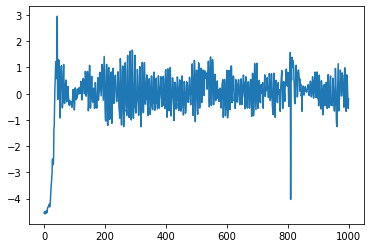

In [543]:
plt.plot(first_component_projected[:,1])

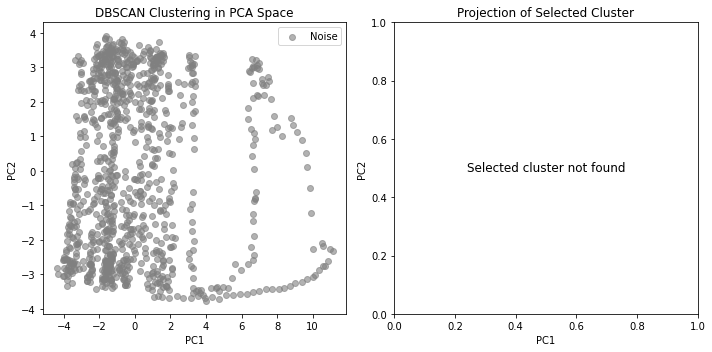

In [544]:
# Cluster the data (e.g., using k-means)
# kmeans = KMeans(n_clusters=3, random_state=2, init='k-means++')
# labels = kmeans.fit_predict(principal_components)

kmeans = DBSCAN(eps=0.6, min_samples=50)
labels = kmeans.fit_predict(principal_components)

# Extract a single cluster
cluster_index = 0  # Replace with the desired cluster index
cluster_mask = labels == cluster_index  # Create a boolean mask

if isinstance(data, pd.DataFrame):
    cluster_data = pca_df.loc[cluster_mask]  # For pandas DataFrame
else:
    cluster_data = pca_df[cluster_mask]      # For NumPy array

# Reproject the original data of the cluster
cluster_pca_projection = principal_components[cluster_mask]  # Extract cluster in PCA space



# Plot DBSCAN clustering
plt.figure(figsize=(10, 5))

# Subplot 1: DBSCAN clustering
plt.subplot(1, 2, 1)
unique_labels = set(labels)
for cluster_index in unique_labels:
    if cluster_index == -1:
        # Noise points
        cluster_points = principal_components[labels == cluster_index]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c='gray', label='Noise', alpha=0.6)
    else:
        cluster_points = principal_components[labels == cluster_index]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_index}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering in PCA Space')
plt.legend()

# Subplot 2: Selected cluster projection
plt.subplot(1, 2, 2)
selected_cluster_index = 0  # Change to desired cluster index
if selected_cluster_index in unique_labels and selected_cluster_index != -1:
    cluster_mask = labels == selected_cluster_index
    cluster_pca_projection = principal_components[cluster_mask]
    plt.scatter(cluster_pca_projection[:, 0], cluster_pca_projection[:, 1], c='blue', label=f'Cluster {selected_cluster_index}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'Projection of Selected Cluster {selected_cluster_index}')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Selected cluster not found', ha='center', va='center', fontsize=12)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Projection of Selected Cluster')

plt.tight_layout()
plt.show()

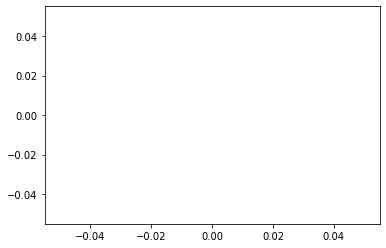

In [545]:
# Plot back-projection of main cluster
cluster_0 = [sum(cluster_pca_projection[i]) for i in range(len(cluster_pca_projection))]
plt.plot(cluster_0)

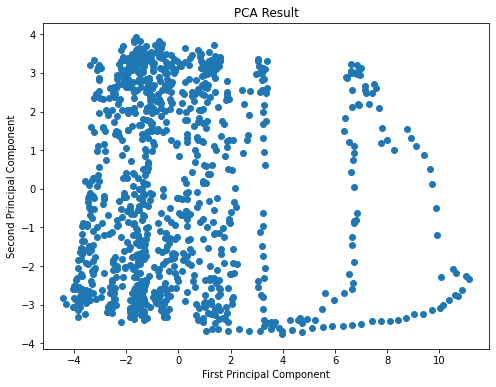

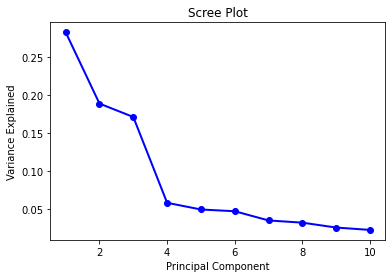

In [546]:
# Scatter plot of first two components and scree plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Result')
plt.show()

# PCA Scree Plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()


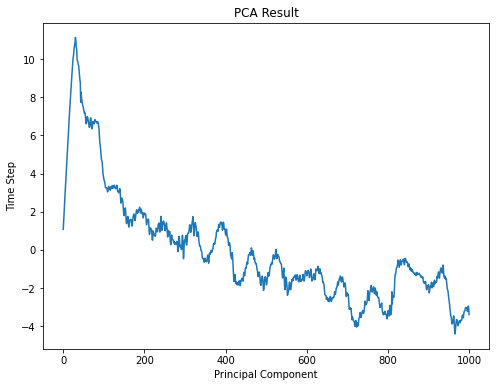

In [547]:
# Plot of first component

plt.figure(figsize=(8, 6))
plt.plot(pca_df['PC1'])
plt.xlabel('Principal Component')
plt.ylabel('Time Step')
plt.title('PCA Result')
plt.show()

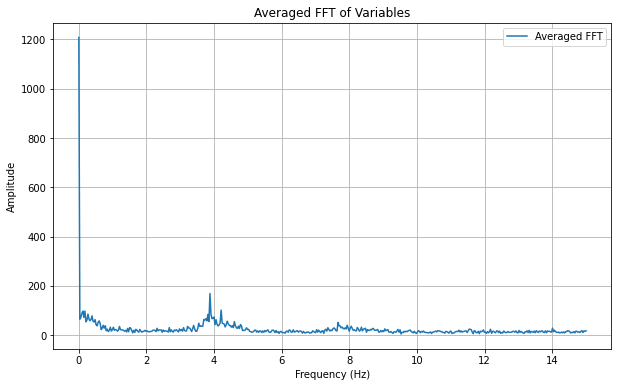

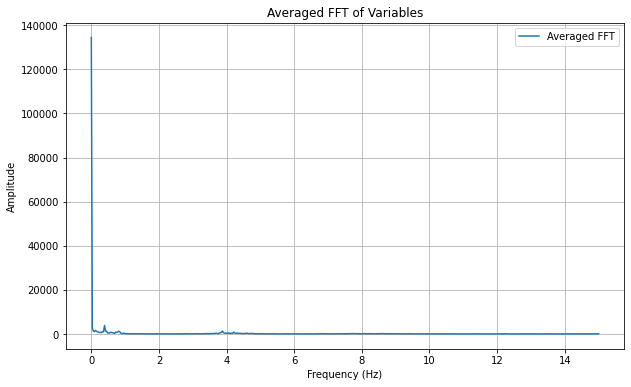

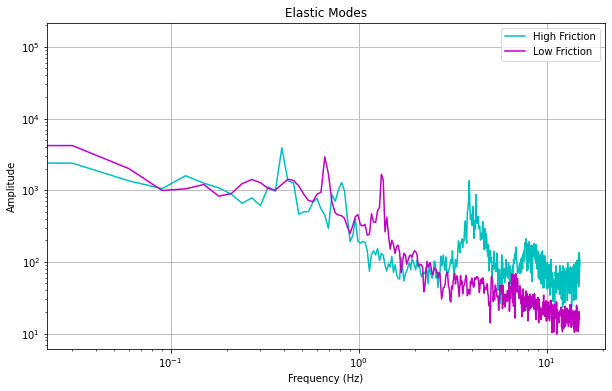

In [554]:
# Plot averaged FFT
dist_df = pd.DataFrame()
dist_df["timestamp"] = robot_df["timestamp"]
for i in range(1,len(node_list)):
    name = str(i)+"_dist"
    dist_df[name] = robot_df[name]

angle_df = pd.DataFrame()
angle_df["timestamp"] = robot_df["timestamp"]
for i in range(1,len(node_list)):
    name = str(i)+"_angle"
    angle_df[name] = robot_df[name]


# rub_angles_freqs, rub_angles_fft = plot_averaged_fft(angle_df)
# rub_dist_freqs, rub_dist_fft = plot_averaged_fft(dist_df)

plt.figure(figsize=(10, 6))
plt.loglog(rub_dist_freqs, rub_dist_fft, label='High Friction', color = 'c')
plt.loglog(plas_dist_freqs, plas_dist_fft, label='Low Friction', color = 'm')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
# plt.ylim(0,1000)
plt.title("Elastic Modes")
plt.grid()
plt.legend()
# plt.savefig('elastic_modes.png')
plt.show()

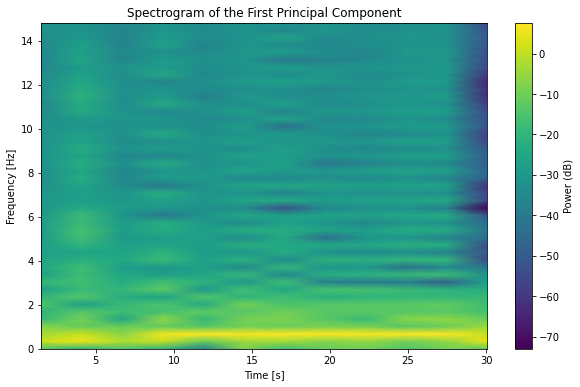

In [396]:
# Spectrogram of component
nperseg = 89  # Length of each segment
noverlap = 4  # Overlap between segments (50% overlap)

# Compute the spectrogram
spec_data = first_component_projected[:,1] # np.array(cluster_0)
# frequencies, times, Sxx = spectrogram(pca_df['PC1'], fs=fr, nperseg=nperseg)  # Adjust `fs` to your sampling frequency
frequencies, times, Sxx = spectrogram(pca_df["PC5"], fs=fr, nperseg=nperseg)  # Adjust `fs` to your sampling frequency

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title("Spectrogram of the First Principal Component")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.colorbar(label="Power (dB)")
plt.savefig('PC1_Spectrogram.png')
plt.show()

# Get Bounce Angles

In [246]:
# Bend method function defs
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the curvature of a 2D trajectory
def calculate_curvature(x, y):
    dx = np.gradient(x)
    dy = np.gradient(y)
    dx_filt = low_pass_filter(dx, cutoff=cutoff, fs=fs)
    dy_filt = low_pass_filter(dy, cutoff=cutoff, fs=fs)
    ddx = np.gradient(dx_filt)
    ddy = np.gradient(dy_filt)

    # Curvature formula: k = |x'y" - y'x"| / (x'^2 + y'^2)^(3/2)
    numerator = np.abs(dx * ddy - dy * ddx)
    denominator = (dx**2 + dy**2)**1.5
    curvature = numerator / np.maximum(denominator, 1e-10)  # Avoid division by zero
    return curvature

# Function to identify sharp bends and estimate bend angles
def identify_bends(x, y, curvature, threshold):
#     sharp_bends = np.where(curvature > threshold)[0]
    sharp_bends, _  = find_peaks(np.abs(curvature), height=threshold)
    angles = []

    for idx in sharp_bends:
        if idx == 0 or idx == len(x) - 1:
            continue  # Skip endpoints

        # Calculate vectors before and after the point
        vec1 = np.array([x[idx] - x[idx - 1], y[idx] - y[idx - 1]])
        vec2 = np.array([x[idx + 1] - x[idx], y[idx + 1] - y[idx]])

        # Normalize vectors
        vec1 /= np.linalg.norm(vec1)
        vec2 /= np.linalg.norm(vec2)

        # Compute the angle between vectors
        dot_product = np.clip(np.dot(vec1, vec2), -1.0, 1.0)
        angle = np.arccos(dot_product) * (180 / np.pi)  # Convert to degrees
        angles.append((idx, angle))

    return sharp_bends, angles


/var/folders/bb/fz0zm3_96tl62820445bgd5w0000gn/T/ipykernel_46821/3005314055.py:36: RuntimeWarning: invalid value encountered in divide
  vec2 /= np.linalg.norm(vec2)
/var/folders/bb/fz0zm3_96tl62820445bgd5w0000gn/T/ipykernel_46821/3005314055.py:35: RuntimeWarning: invalid value encountered in divide
  vec1 /= np.linalg.norm(vec1)


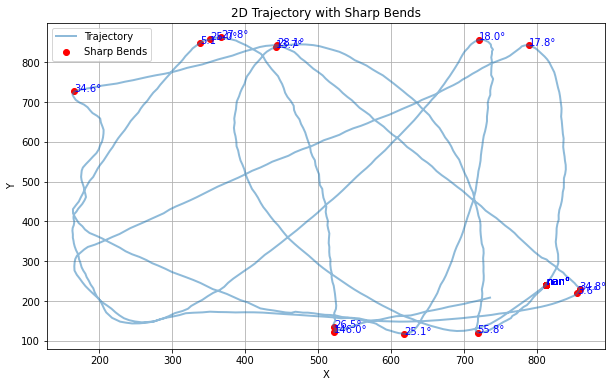

Sharp bends and their angles:
Index: 1, Angle: nan°
Index: 6, Angle: nan°
Index: 9, Angle: nan°
Index: 13, Angle: nan°
Index: 16, Angle: nan°
Index: 19, Angle: nan°
Index: 27, Angle: nan°
Index: 30, Angle: nan°
Index: 32, Angle: nan°
Index: 34, Angle: nan°
Index: 130, Angle: 13.74°
Index: 210, Angle: 55.83°
Index: 291, Angle: 17.83°
Index: 448, Angle: 3.60°
Index: 450, Angle: 34.78°
Index: 522, Angle: 28.14°
Index: 551, Angle: 34.64°
Index: 707, Angle: 18.05°
Index: 780, Angle: 25.13°
Index: 887, Angle: 5.06°
Index: 891, Angle: 24.97°
Index: 895, Angle: 27.77°
Index: 971, Angle: 26.45°
Index: 974, Angle: 145.95°


In [248]:
# Detect Bends
x = robot_df["centroid_x"]
y = robot_df["centroid_y"]
t = robot_df["timestamp"]


# Calculate curvature
curvature = calculate_curvature(x, y)

# Identify sharp bends (adjust threshold as needed)
threshold = 0.02
sharp_bends, angles = identify_bends(x, y, curvature, threshold)

# Plot the trajectory and highlight sharp bends
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Trajectory", lw=2, alpha = 0.5)
plt.scatter(x[sharp_bends], y[sharp_bends], color="red", label="Sharp Bends")

# Annotate bend angles
for idx, angle in angles:
    plt.text(x[idx], y[idx], f"{angle:.1f}°", color="blue", fontsize=10)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Trajectory with Sharp Bends")
plt.legend()
plt.grid()
plt.show()

# Print bend angles
print("Sharp bends and their angles:")
for idx, angle in angles:
    print(f"Index: {idx}, Angle: {angle:.2f}°")


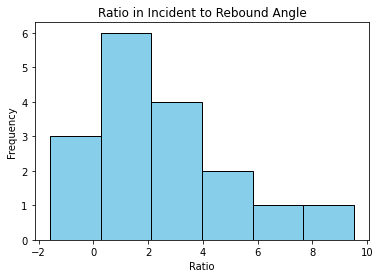

In [185]:
# Create histogram
plt.hist(ratios, bins='auto', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.title('Ratio in Incident to Rebound Angle')
plt.savefig('rebound_hist.png')
# Display the plot
plt.show()


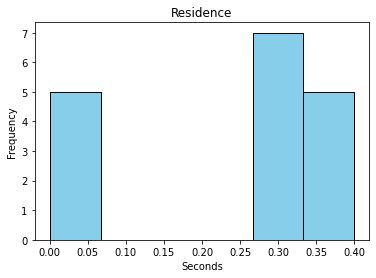

In [186]:
# Create histogram
plt.hist(residence_times, bins='auto', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.title('Residence')
# plt.savefig('rebound_hist.png')
# Display the plot
plt.show()